## Predicting Default on Payments of Credit Card Clients

# 2. Exploratory Data Analysis & Feature Engineering

Within the scope of ML Analytics Recruitment Challenge, the goal of this notebook is to perform exploratory data analysis (EDA).


***

### Main Insights:

<div class="alert alert-block alert-info">
   The training dataset contains originally 24,000 observations, 21 numeric variables, and 3 categorical variables, with a highly imbalanced target variable.
</div>

<div class="alert alert-block alert-info">
    There are outliers in variables related to bill statements and payment amounts, and variables have high standard deviation values, indicating higher data variability.
</div>

<div class="alert alert-block alert-info">
    The variables most correlated to the target are payment statuses and limit balance.
</div>

<div class="alert alert-block alert-info">
    Demographically, customers who are more likely to default are male, married, with lower education levels, and between 40 and 60 years old.
</div>

<div class="alert alert-block alert-info">
    Financially, customers who are more likely to default have lower credit limits, delayed payments, lower average paid amounts, and bill statement amounts between 10,000 and 50,000 dollars. These customers occasionally perform overpayments.
</div>

<div class="alert alert-block alert-info">
    Customers who frequently pay on time have higher average credit limits than those with payment delays.
</div>

<div class="alert alert-block alert-info">
    Mosaic plots show independence between outliers and target classes in the <i>limit_bal</i> and <i>pay_amtX</i> variables.
</div>

<div class="alert alert-block alert-info">
    During feature engineering, 42 new variables were created. These variables include change rates in bill statements, paid amounts, differences between bill statements and paid amounts, and total amount paid by client, among others. 
</div>

***


In [1]:
# !pip install pandas-profiling
# !pip install statsmodels==0.13.5

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import warnings

from pandas_profiling import ProfileReport
from statsmodels.graphics.mosaicplot import mosaic

seed = 17
np.random.seed(seed)

pd.set_option("display.max_rows", 100)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="bwr_r")

cm = sns.light_palette("red", as_cmap=True)

warnings.filterwarnings("ignore")

C:\Users\mafal\AppData\Local\Temp\ipykernel_3620\2505059298.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### Utils

Definition of functions to simplify recurring tasks:

In [3]:
def map_values(col, mapping):
    """Function to encode a column in a dataframe."""
    return col.map(mapping)


def plot_pie_and_bar_plots(df, col, figsize=(14,4)):
    """Plots the count of a given variable, as well as its relationship with the target variable."""
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    df[col].value_counts().plot(kind="pie", ax=axes[0], legend=False, autopct="%.2f%%", fontsize=10, shadow=True)
    crosstable = pd.crosstab(df[col], df["target"], normalize='index')
    crosstable.plot.bar(stacked=True, ax=axes[1])

    plt.show()
    

def generate_crosstab_with_percentages(index_col, cols, normalize=True, margins=True, add_percentage=False):
    """Returns a crosstable with values in percentage format rounded up to 2 decimal places."""
    crosstab = round(
        pd.crosstab(
            index=index_col,
            columns=cols,
            normalize=normalize,
            margins=margins
        )*100, 2
    )
    
    if add_percentage:
        crosstab = crosstab.astype(str).apply(lambda x: x + "%")
    
    return crosstab


def outlier_iqr(data, column):
    """
    Identifies potential outliers using the interquartilic range criteria.
    
    Parameters
    ----------
      :param: <data> pandas dataframe object
      :param: <column> string with column name
      :output: <outlier cutpoint>,<potential outliers dataframe extracted from dataset>
    """
    out_cut = np.nanpercentile(data[column], 75) + (sp.stats.iqr(data[column], nan_policy = 'omit') * 1.5)
    out = data[(data[column] > out_cut) | (data[column] < -out_cut)]
    print(f"Potential outliers: {round(len(out)/len(data) * 100,3)}% of dataset rows\n{len(out)} cases below or above 1.5 IQR from 1Q/3Q")
    return out_cut, out

### Loading the data

In [4]:
df = pd.read_csv("../data/train_data.csv")
df.sample(3)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
20114  8830   240000.0    2          1         2   35     -2     -2     -2   
6176   4504   280000.0    2          2         2   30     -1     -1     -1   
22910  9837   110000.0    2          2         1   46     -2     -1      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
20114     -2  ...     2429.0        0.0      799.0       0.0       0.0   
6176       0  ...     2769.0        0.0        0.0     207.0    3516.0   
22910      0  ...    78622.0    78430.0    78120.0   86367.0    2846.0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
20114    2429.0       0.0     799.0   17125.0                           0  
6176        0.0       0.0       0.0       0.0                           0  
22910    2755.0    2838.0    2808.0    2740.0                           0  

[3 rows x 25 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          24000 non-null  int64  
 1   LIMIT_BAL                   24000 non-null  float64
 2   SEX                         24000 non-null  int64  
 3   EDUCATION                   24000 non-null  int64  
 4   MARRIAGE                    24000 non-null  int64  
 5   AGE                         24000 non-null  int64  
 6   PAY_0                       24000 non-null  int64  
 7   PAY_2                       24000 non-null  int64  
 8   PAY_3                       24000 non-null  int64  
 9   PAY_4                       24000 non-null  int64  
 10  PAY_5                       24000 non-null  int64  
 11  PAY_6                       24000 non-null  int64  
 12  BILL_AMT1                   24000 non-null  float64
 13  BILL_AMT2                   240

In [6]:
# Rename and uniformize columns' names:
df.rename(columns={"default.payment.next.month": "target", "PAY_0": "PAY_1"}, inplace=True)
df.columns = [col.lower() for col in df.columns]
df.drop(columns=["id"], axis=1, inplace=True)

df.sample(3)

limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  pay_4  \
13770    80000.0    1          3         1   27      2     -1      0      0   
3351    110000.0    2          2         1   29      0      0      0      0   
10827   140000.0    1          3         1   59     -1     -1     -1     -1   

       pay_5  ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  \
13770      0  ...     1170.0      780.0      780.0    1149.0    1000.0   
3351       0  ...    62306.0    63768.0    65239.0    2505.0    2500.0   
10827     -1  ...     2061.0        0.0     3035.0    3447.0       0.0   

       pay_amt3  pay_amt4  pay_amt5  pay_amt6  target  
13770       0.0       0.0       0.0    2440.0       1  
3351     2500.0    2500.0    2500.0    2640.0       0  
10827    2061.0       0.0    3035.0    2302.0       0  

[3 rows x 24 columns]

### Profile report

**Main insights:**
- The train set is composed by 24000 observations, 21 numeric variables and 3 categorical variables;
- After removing the 'ID' column, the dataframe contains 24 duplicate rows;
- The target is highly imbalanced, with only 22% of the observations belonging to the class of interest;
- There are some outliers in variables related to bill statements and payment amounts; 
- Variables regarding bill statements and payment amounts have standard-deviation values greater than their mean values, which indicates a higher dispersion and variability of the data points;
- The variables 'sex' and 'marriage' are encoded in an ordinal fashion (from 1 to n, where n = number of categories), which may be misleading;
- The variables most correlated to the target are the payment statuses and the limit balance;
- Variables related to past payments have hight correlations:
    - The variables related to bill statements (BILL_AMTX) are highly correlated among themselves;
    - The variables related to payment statuses (PAY_X) are moderately to highly correlated among themselves.

In [7]:
profile = ProfileReport(df, title="Default of Payments of Credit Card")
#profile.to_widgets()

<AxesSubplot:>

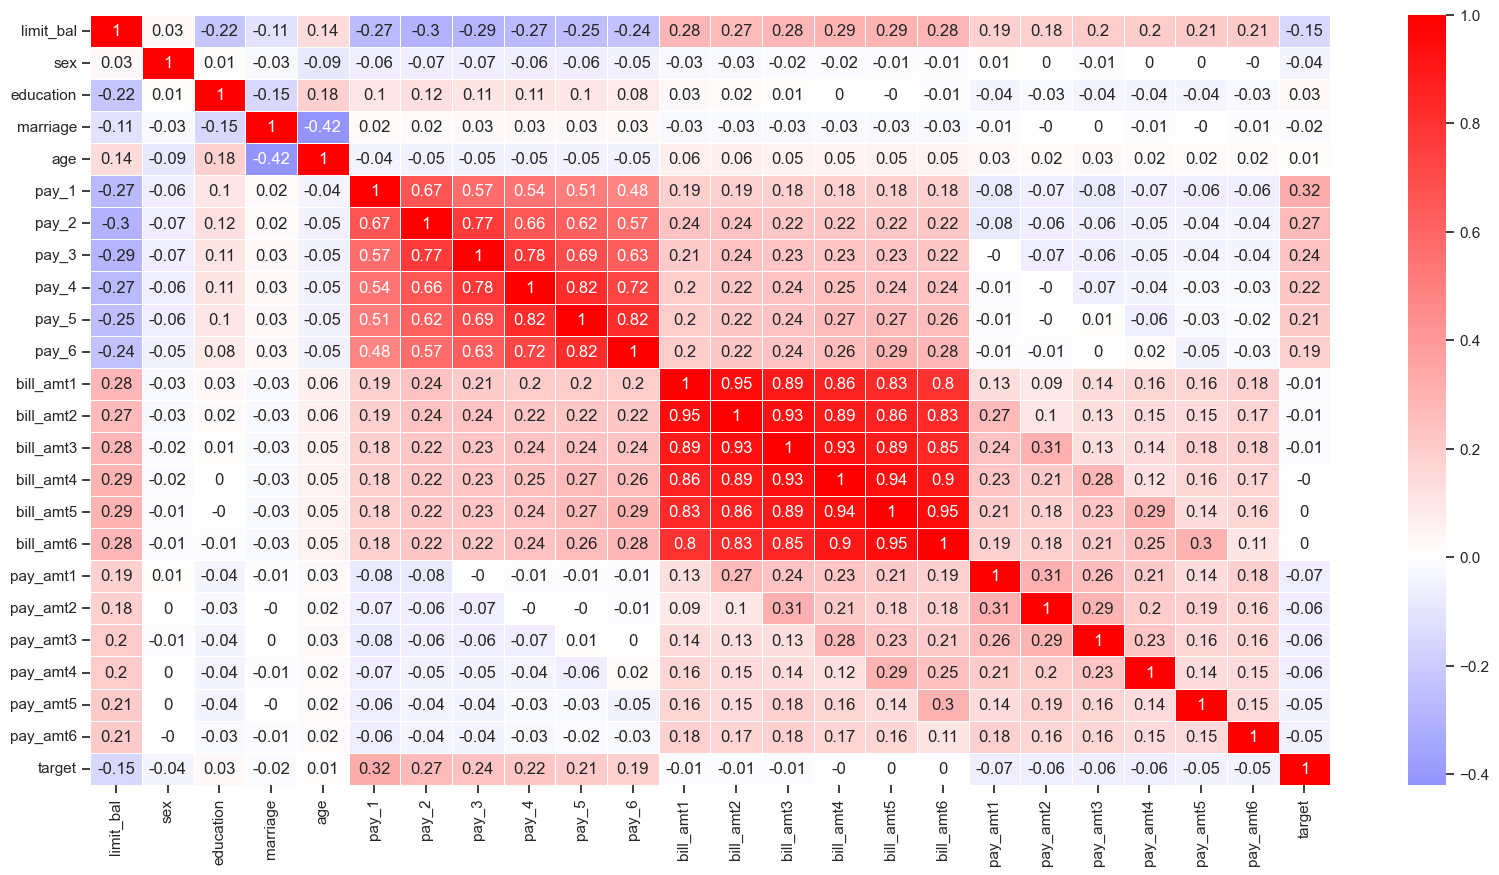

In [8]:
df_correlations = round(df.corr(), 2)

plt.figure(figsize=(20,10))
sns.heatmap(df_correlations, annot=True, linewidths=0.5, center=0.0, cmap="bwr")

In [9]:
cat_cols = ["target", "sex", "education", "marriage", "pay_1", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]
num_cols = ["target", "age", "limit_bal", "bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6", 
            "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]

subset = ["mean", "std", "min", "25%", "50%", "75%", "max"]

cat_stats = df[cat_cols].describe().T
display(cat_stats.style.background_gradient(cmap=cm, axis=0, subset=subset).set_precision(2))

num_stats = df[num_cols].describe().T
display(num_stats.style.background_gradient(cmap=cm, axis=0, subset=subset).set_precision(2))

In [10]:
original_size = len(df)

df.drop_duplicates(inplace=True)

print(f"Dropped {original_size - len(df)} duplicate rows.")

Dropped 20 duplicate rows.


### Demographic variables

**Main insights:**
- The customers database is composed of 60% females;
- More than 82% of the customers have attended graduate school or university;
- The average age of a customer is 35 years old, with the median being 34 years old;
- Customers who are more likely to default exhibit some of the following characteristics:
	- Being male;
	- Being married;
	- Having finished high school or obtained a university diploma (although this association does not appear with customers who have finished graduate school);
	- Being between 40 and 60 years old;
- On the other hand, customers who apparently default less exhibit some of the following characteristics:
	- Being female;
	- Having finished graduate school;
	- Being between 30 and 40 years old;
- Regarding demographic variables, *sex* and *education* emerge as the best potential discriminators towards customers who defaulted;
- According to the mosaic plot, the age group from 20 to 30 is fully independent of the target variable;
- Considering the results of the mosaic plots, the "Unknown" and "Others" classes in the *marriage* variable can be merged, as they appear weakly correlated to the target. 

In order to make the analysis and interpretation of the data easier to understand, let's remove the encoding of categorical variables.

In [11]:
# Sex:
mapping = {
    1: "Male", 
    2: "Female"
}
df["sex"] = map_values(df["sex"], mapping)

# Marrital_Status:
mapping = {
    1: "Married", 
    2: "Single", 
    3: "Others", 
    0: "Unknown"
}
df["marriage"] = map_values(df["marriage"], mapping)

# Education:
mapping = {
    1: "Graduate School", 
    2: "University", 
    3: "High School", 
    4: "Others",
    5: "Unknown",
    6: "Unknown"
}
df["education"] = map_values(df["education"], mapping)

display(df["sex"].value_counts())
display(df["marriage"].value_counts())
display(df["education"].value_counts())

Female    14464
Male       9516
Name: sex, dtype: int64

Single     12782
Married    10902
Others       251
Unknown       45
Name: marriage, dtype: int64

University         11246
Graduate School     8450
High School         3919
Unknown              252
Others               103
Name: education, dtype: int64

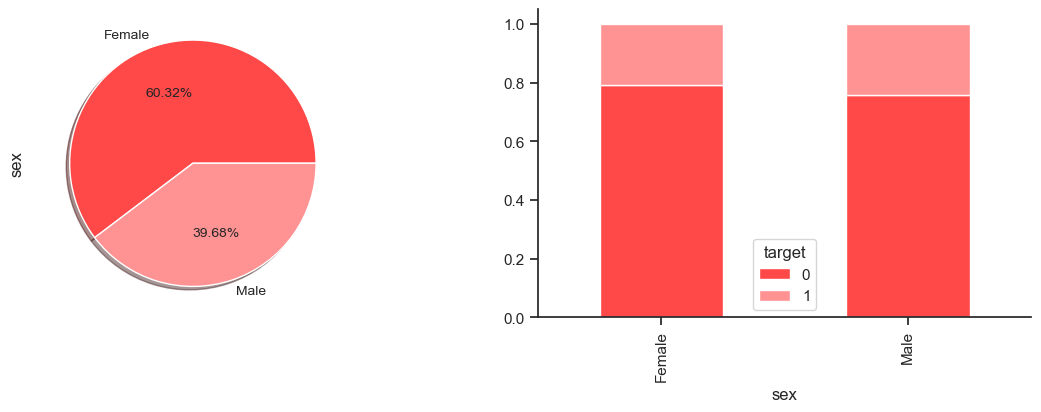

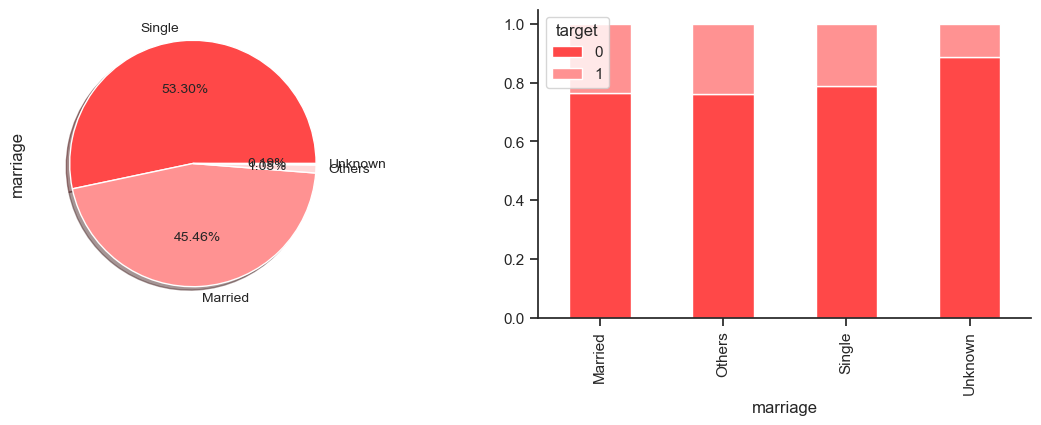

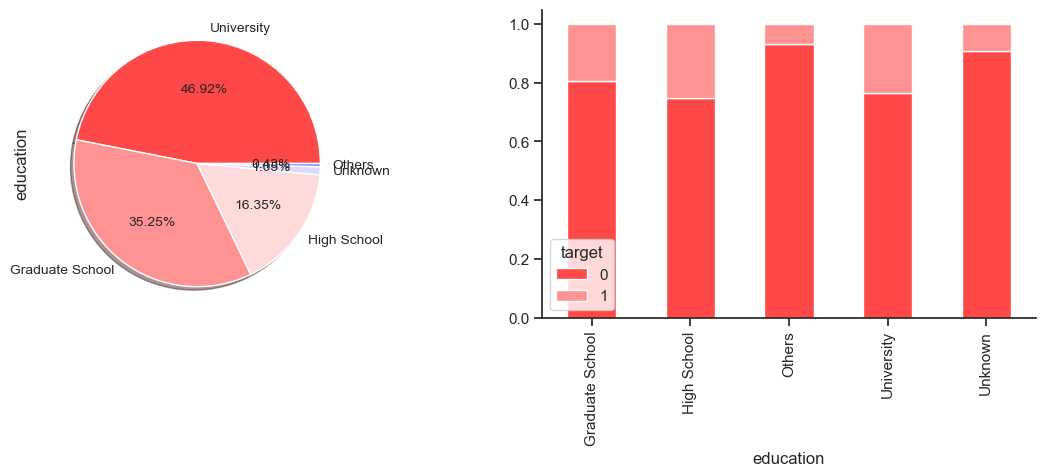

In [12]:
plot_pie_and_bar_plots(df, "sex") 
plot_pie_and_bar_plots(df, "marriage") 
plot_pie_and_bar_plots(df, "education")

Text(0.5, 1.0, 'Age Distribution by Default Payment')

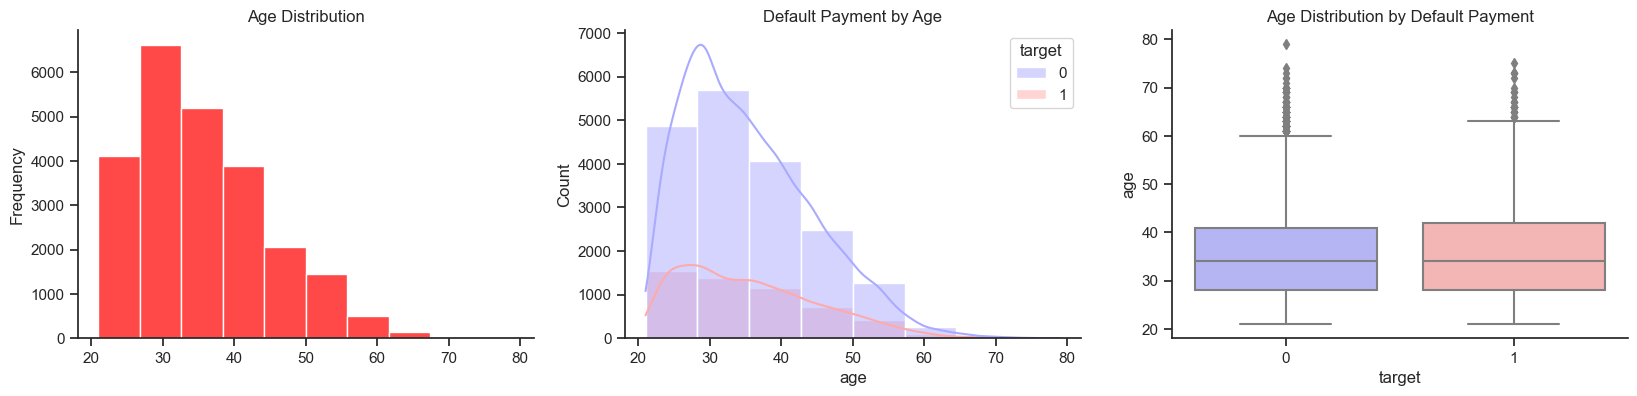

In [13]:
# The age of customers ranges from 21 to 79:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

h = df["age"].plot(kind="hist", ax=axes[0])
h.set_title("Age Distribution")

h = sns.histplot(data=df, x="age", hue="target", kde=True, bins=8, palette="bwr", ax=axes[1])
h.set_title("Default Payment by Age")

h = sns.boxplot(data=df, x="target", y="age", palette="bwr", ax=axes[2])
h.set_title("Age Distribution by Default Payment")

In [14]:
print("From all customers who defaulted payment...")
print("... how many of them are women? And how many of them are men?")
display(df[df["target"] == 1]["sex"].value_counts(normalize=True))

print("\n... how many of them are married?")
display(df[df["target"] == 1]["marriage"].value_counts(normalize=True))

print("\n... how are their education references?")
display(df[df["target"] == 1]["education"].value_counts(normalize=True))

From all customers who defaulted payment...
... how many of them are women? And how many of them are men?


Female    0.565127
Male      0.434873
Name: sex, dtype: float64


... how many of them are married?


Single     0.508200
Married    0.479548
Others     0.011310
Unknown    0.000943
Name: marriage, dtype: float64


... how are their education references?


University         0.498021
Graduate School    0.310273
High School        0.186051
Unknown            0.004336
Others             0.001320
Name: education, dtype: float64

In [15]:
print("From all customers who are not defaulting payment...")
print("... how many of them are women? And how many of them are men?")
display(df[df["target"] == 0]["sex"].value_counts(normalize=True))

print("\n... how many of them are married?")
display(df[df["target"] == 0]["marriage"].value_counts(normalize=True))

print("\n... how are their education references?")
display(df[df["target"] == 0]["education"].value_counts(normalize=True))

From all customers who are not defaulting payment...
... how many of them are women? And how many of them are men?


Female    0.613976
Male      0.386024
Name: sex, dtype: float64


... how many of them are married?


Single     0.540080
Married    0.447550
Others     0.010228
Unknown    0.002142
Name: marriage, dtype: float64


... how are their education references?


University         0.460970
Graduate School    0.364533
High School        0.157085
Unknown            0.012269
Others             0.005143
Name: education, dtype: float64

In [16]:
crosstable = generate_crosstab_with_percentages(index_col=df["education"], cols=[df["sex"], df["marriage"]], margins=False).T
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))

print("Note: the values of the table above are in percentage.")

Note: the values of the table above are in percentage.


In [17]:
generate_crosstab_with_percentages(index_col=df["target"], cols=[df["sex"], df["marriage"]], add_percentage=True).T

target                0       1     All
sex    marriage                        
Female Married   21.98%   6.11%  28.09%
       Others      0.5%   0.13%   0.63%
       Single    25.22%   6.26%  31.48%
       Unknown    0.12%   0.01%   0.13%
Male   Married   12.87%    4.5%  17.38%
       Others      0.3%   0.13%   0.42%
       Single    16.84%   4.98%  21.83%
       Unknown    0.05%   0.01%   0.06%
All              77.88%  22.12%  100.0%

In [18]:
generate_crosstab_with_percentages(index_col=df["target"], cols=[df["education"], df["marriage"]], add_percentage=True).T

target                         0       1     All
education       marriage                        
Graduate School Married    9.71%   2.58%  12.29%
                Others     0.12%   0.05%   0.17%
                Single    18.54%   4.24%  22.77%
                Unknown    0.02%    0.0%   0.02%
High School     Married    7.03%   2.47%    9.5%
                Others     0.27%   0.08%   0.35%
                Single      4.8%   1.55%   6.35%
                Unknown    0.13%   0.02%   0.15%
Others          Married    0.18%   0.01%   0.19%
                Others     0.01%    0.0%   0.01%
                Single     0.21%   0.02%   0.23%
University      Married   17.43%   5.49%  22.92%
                Others     0.38%   0.13%    0.5%
                Single    18.06%    5.4%  23.47%
                Unknown    0.02%    0.0%   0.02%
Unknown         Married     0.5%   0.05%   0.56%
                Others     0.01%    0.0%   0.01%
                Single     0.44%   0.04%   0.48%
All                       77.87%  22.13%  100.0%

In [19]:
generate_crosstab_with_percentages(index_col=df["target"], cols=[df["education"], df["sex"]], add_percentage=True).T

target                       0       1     All
education       sex                           
Graduate School Female  16.93%   3.81%  20.73%
                Male    11.46%   3.06%  14.52%
High School     Female   7.44%   2.31%   9.75%
                Male     4.79%   1.81%    6.6%
Others          Female   0.29%   0.01%    0.3%
                Male     0.11%   0.02%   0.13%
University      Female  22.57%   6.32%  28.89%
                Male    13.32%    4.7%  18.02%
Unknown         Female   0.58%   0.06%   0.64%
                Male     0.38%   0.04%   0.41%
All                     77.87%  22.13%  100.0%

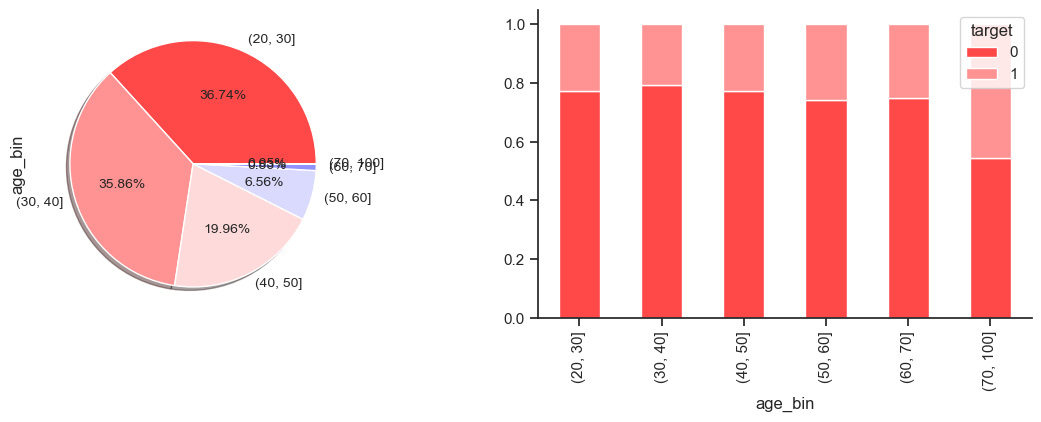

In [20]:
# Create a new variable by cutting the age variable into intervals:
bins = [20, 30, 40, 50, 60, 70, 100]
df['age_bin'] = pd.cut(df['age'], bins)
plot_pie_and_bar_plots(df, "age_bin")

#### Sex x Target

target      0     1
sex                
Female  11466  2998
Male     7209  2307

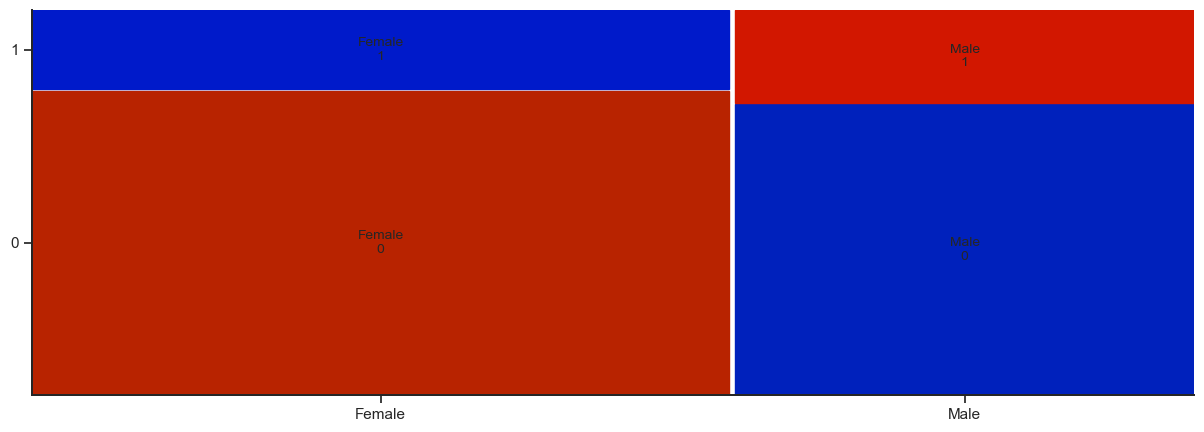

In [21]:
crosstable = pd.crosstab(df["sex"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=True)

display(crosstable)

#### Marriage x Target

target        0     1
marriage             
Married    8358  2544
Others      191    60
Single    10086  2696
Unknown      40     5

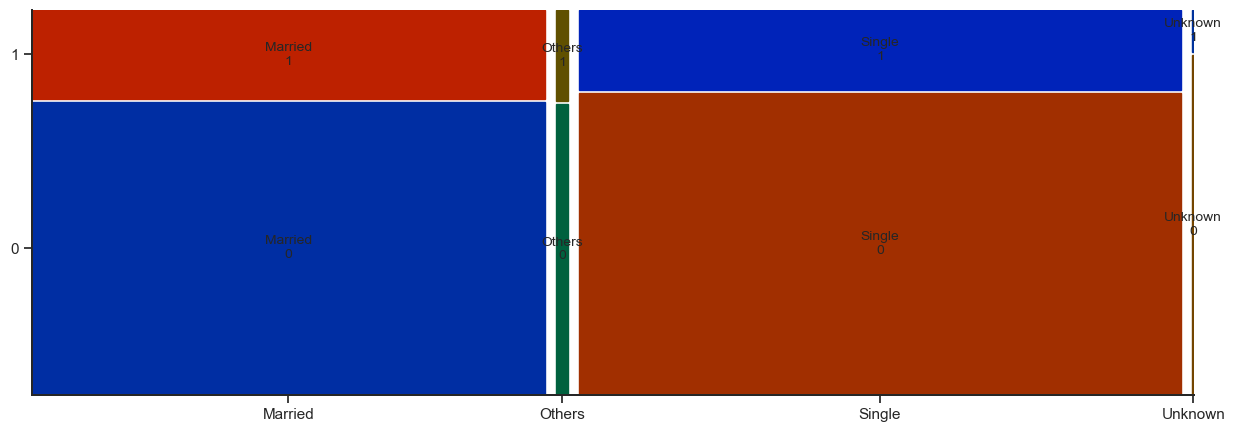

In [22]:
crosstable = pd.crosstab(df["marriage"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=True, gap=0.01)

display(crosstable)

#### Education x Target

target              0     1
education                  
Graduate School  6804  1646
High School      2932   987
Others             96     7
University       8604  2642
Unknown           229    23

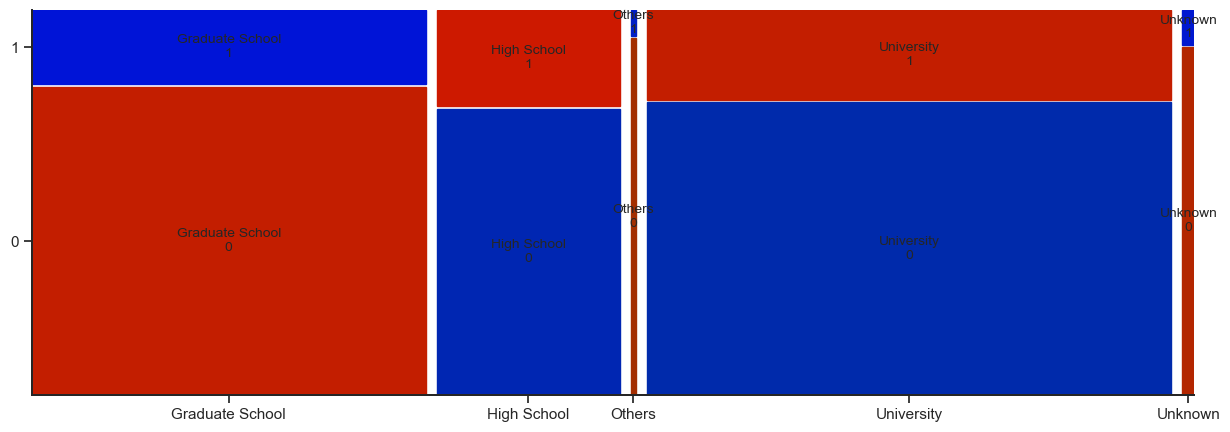

In [23]:
crosstable = pd.crosstab(df["education"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=True, gap=0.01)

display(crosstable)

#### Age x Target

target        0     1
age_bin              
(20, 30]   6808  2002
(30, 40]   6837  1762
(40, 50]   3708  1078
(50, 60]   1166   408
(60, 70]    150    50
(70, 100]     6     5

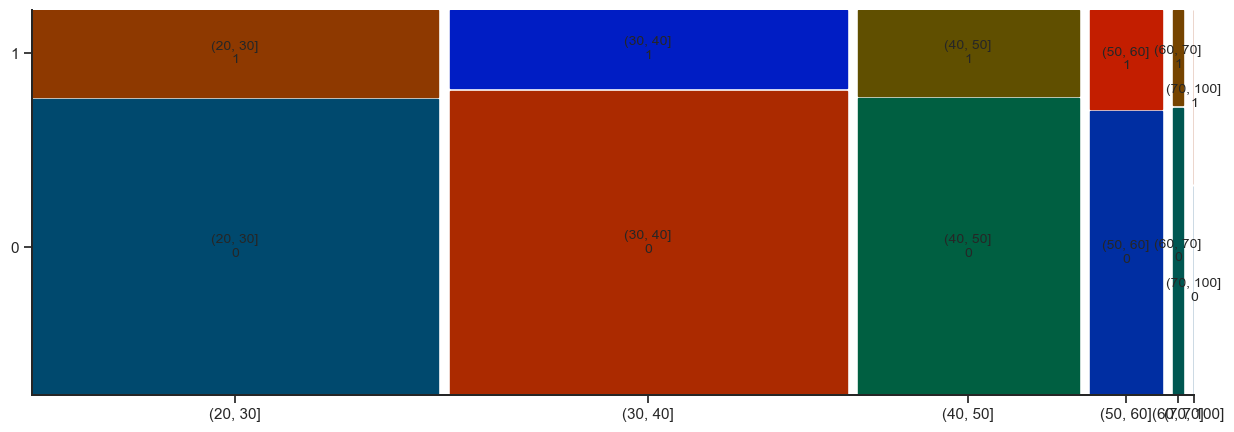

In [24]:
crosstable = pd.crosstab(df["age_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=True, gap=0.01)

display(crosstable)

### Financial variables

**Main insights:**
- 25% of the customers in the database have been given a credit limit of 50,000 dollars or less, and 50% have a credit limit of 140,000 dollars or less;
- Customers who are more likely to default exhibit some of the following characteristics:
	- Have lower credit limits;
	- Delayed payments;
	- Lower average paid amounts (0 dollars to 2,500 dollars);
	- Bill statement amounts ranging from 10,000 dollars to 50,000 dollars;
	- May also overpaid in some previous months.
- In contrast, customers who are less likely to default have some of the following characteristics:
	- Have higher credit limits;
	- Do not delaying their payments;
	- Bill statement amounts very low (up to 10,000$) or very high (more than 100,000 dollars);
	- Consistently higher monthly payment averages.
- Mosaic plots shows independence between the outliers and target classes in the *limit_bal* and *pay_amtX* variables;
- Customers who frequently pay on time have higher average of credit limits than those  with payment delays.

#### Limit bal

Text(0.5, 1.0, 'Limit Balance Distribution by Default Payment')

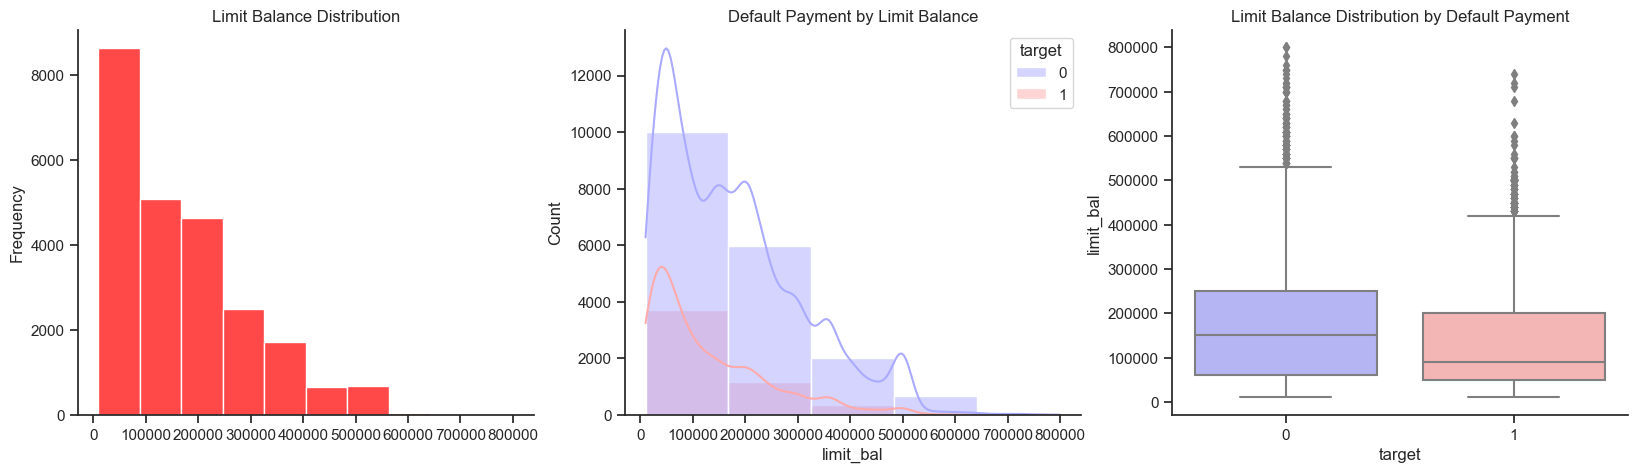

In [25]:
# The limit balance of customers ranges from 10000 to 800000:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

h = df["limit_bal"].plot(kind="hist", ax=axes[0])
h.set_title("Limit Balance Distribution")

h = sns.histplot(data=df, x="limit_bal", hue="target", kde=True, bins=5, palette="bwr", ax=axes[1])
h.set_title("Default Payment by Limit Balance")

h = sns.boxplot(data=df, x="target", y="limit_bal", ax=axes[2], palette="bwr")
h.set_title("Limit Balance Distribution by Default Payment")

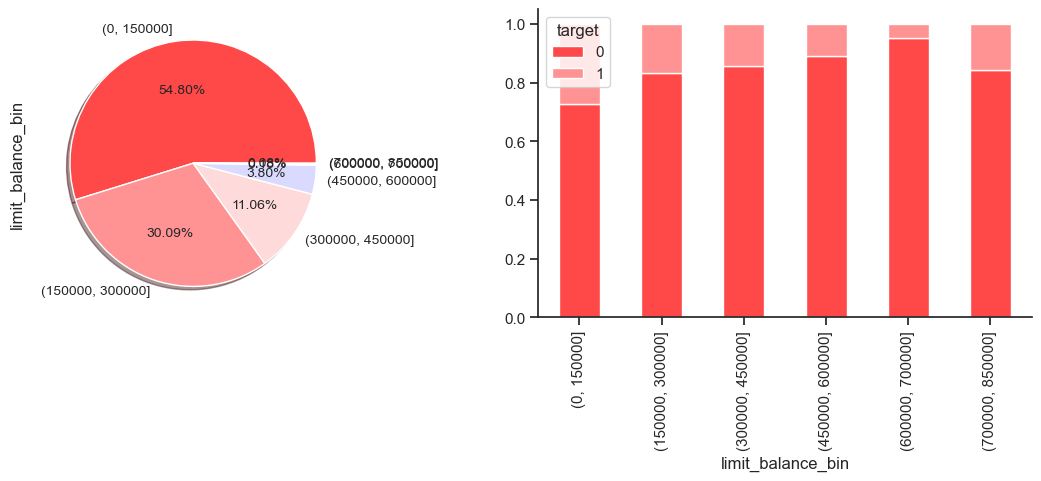

In [26]:
# Create a new variable by cutting the limit_bal variable into intervals:
bins = [0, 150000, 300000, 450000, 600000, 700000, 850000]

df['limit_balance_bin'] = pd.cut(df['limit_bal'], bins)

plot_pie_and_bar_plots(df, "limit_balance_bin")

#### Repayment status variables: Pay_1, Pay_2, Pay_3, Pay_4, Pay_5, Pay_6

These variables are encoded as follows:
- *-2:* No consumption; 
- *-1:* Paid in full; 
- *0:* Revolving credit usage; 
- *n:* Payment delay of *n* months, where n = 1, 2, ..., 9 or more months.

<br>


Although the original documentation refers the value "9", this value doesn't appear in the training data. 


In [27]:
# Example of repayment variable:
df["pay_1"].value_counts()

# Note: the remaining five repayment variables have the same unique values.

 0    11768
-1     4554
 1     2961
-2     2195
 2     2131
 3      257
 4       62
 5       19
 8       18
 6        8
 7        7
Name: pay_1, dtype: int64

In [28]:
# Repayment variables:
mapping = {
    -2: "No consumption",
    -1: "Paid in full",
    0: "Revolving credit usage", 
    1: "1 month delay",
    2: "2 months delay",
    3: "3 months delay",
    4: "4 months delay",
    5: "5 months delay",
    6: "6 months delay",
    7: "7 months delay",
    8: "8 months delay",
    9: "9+ months delay"
}

df["pay_1"] = map_values(df["pay_1"], mapping)
df["pay_2"] = map_values(df["pay_2"], mapping)
df["pay_3"] = map_values(df["pay_3"], mapping)
df["pay_4"] = map_values(df["pay_4"], mapping)
df["pay_5"] = map_values(df["pay_5"], mapping)
df["pay_6"] = map_values(df["pay_6"], mapping)

In [29]:
crosstable = generate_crosstab_with_percentages(index_col=df["pay_1"], cols=[df["target"]], margins=False)
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))
print("Note: the values of the table above are in percentage.")

crosstable = generate_crosstab_with_percentages(index_col=df["pay_2"], cols=[df["target"]], margins=False)
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))
print("Note: the values of the table above are in percentage.")

crosstable = generate_crosstab_with_percentages(index_col=df["pay_3"], cols=[df["target"]], margins=False)
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))
print("Note: the values of the table above are in percentage.")

crosstable = generate_crosstab_with_percentages(index_col=df["pay_4"], cols=[df["target"]], margins=False)
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))
print("Note: the values of the table above are in percentage.")

crosstable = generate_crosstab_with_percentages(index_col=df["pay_5"], cols=[df["target"]], margins=False)
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))
print("Note: the values of the table above are in percentage.")

crosstable = generate_crosstab_with_percentages(index_col=df["pay_6"], cols=[df["target"]], margins=False)
display(crosstable.style.background_gradient(cmap=cm, axis=0).set_precision(2))
print("Note: the values of the table above are in percentage.")

Note: the values of the table above are in percentage.


Note: the values of the table above are in percentage.


Note: the values of the table above are in percentage.


Note: the values of the table above are in percentage.


Note: the values of the table above are in percentage.


Note: the values of the table above are in percentage.


#### Amount of bill statement variables: bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5,  bill_amt6

Number of customers with negative bill statement (September): 489
Number of customers with negative bill statement (August): 544
Number of customers with negative bill statement (July): 536
Number of customers with negative bill statement (June): 554
Number of customers with negative bill statement (May): 535
Number of customers with negative bill statement (April): 575


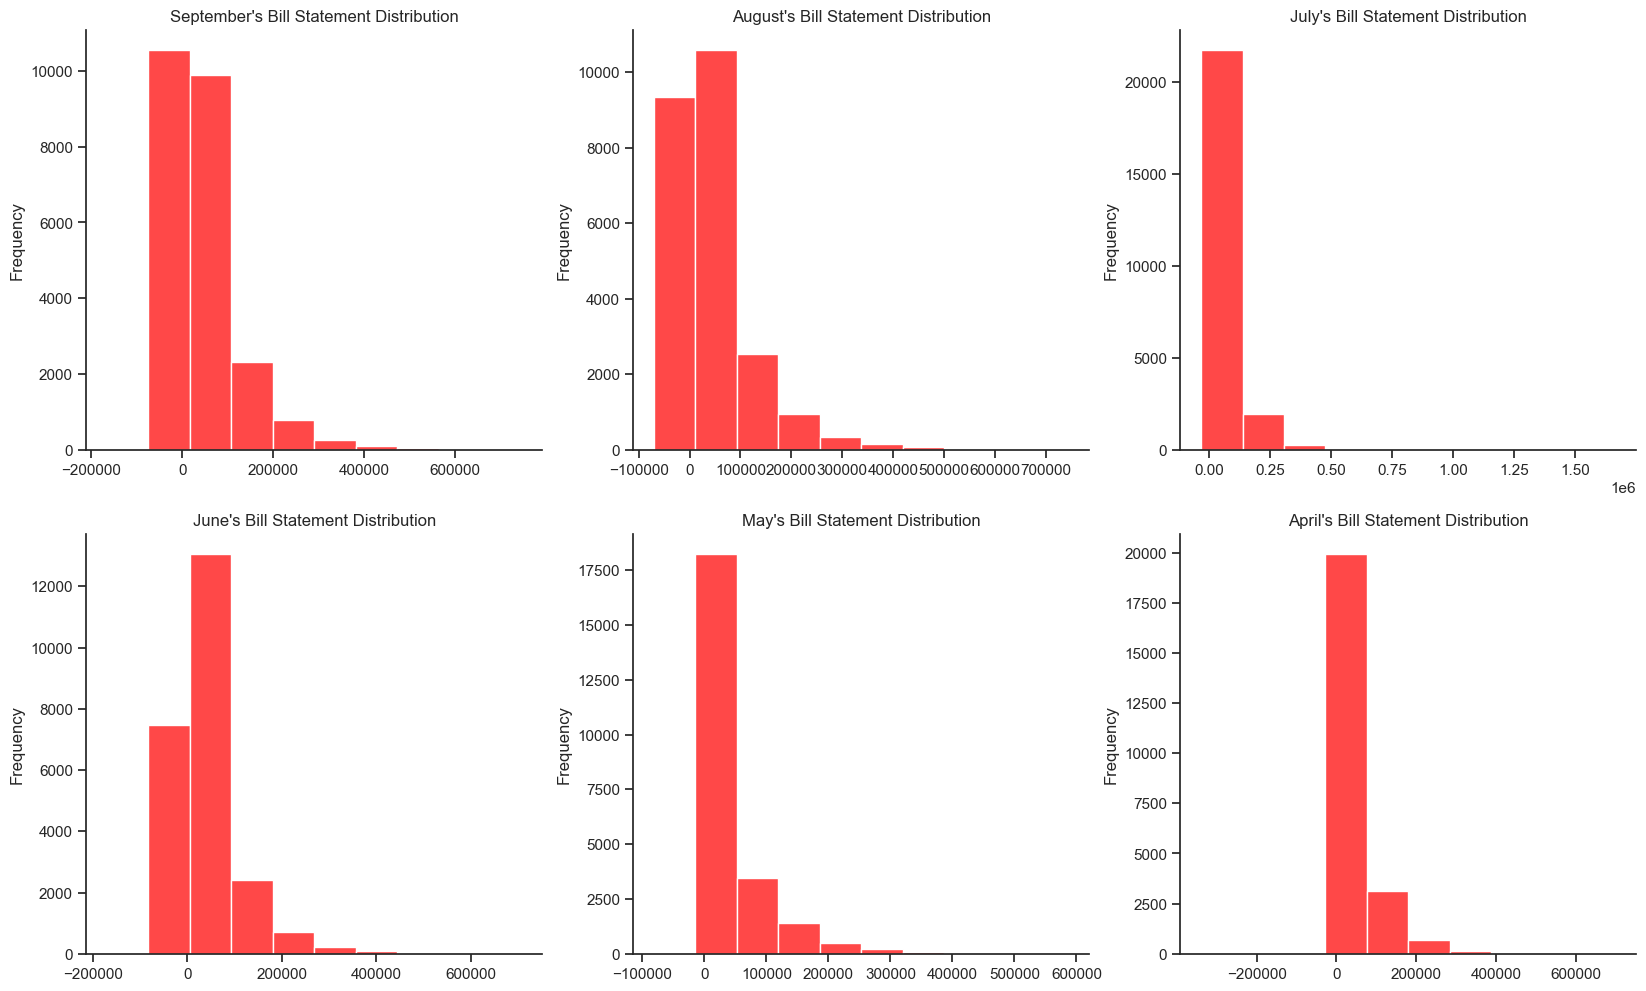

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,12))

h = df["bill_amt1"].plot(kind="hist", ax=axes[0][0])
h.set_title("September's Bill Statement Distribution")

h = df["bill_amt2"].plot(kind="hist", ax=axes[0][1])
h.set_title("August's Bill Statement Distribution")

h = df["bill_amt3"].plot(kind="hist", ax=axes[0][2])
h.set_title("July's Bill Statement Distribution")

h = df["bill_amt4"].plot(kind="hist", ax=axes[1][0])
h.set_title("June's Bill Statement Distribution")

h = df["bill_amt5"].plot(kind="hist", ax=axes[1][1])
h.set_title("May's Bill Statement Distribution")

h = df["bill_amt6"].plot(kind="hist", ax=axes[1][2])
h.set_title("April's Bill Statement Distribution")


print(f"Number of customers with negative bill statement (September): {len(df[df['bill_amt1'] < 0])}")
print(f"Number of customers with negative bill statement (August): {len(df[df['bill_amt2'] < 0])}")
print(f"Number of customers with negative bill statement (July): {len(df[df['bill_amt3'] < 0])}")
print(f"Number of customers with negative bill statement (June): {len(df[df['bill_amt4'] < 0])}")
print(f"Number of customers with negative bill statement (May): {len(df[df['bill_amt5'] < 0])}")
print(f"Number of customers with negative bill statement (April): {len(df[df['bill_amt6'] < 0])}")

#### Amount of previous payment: pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6 

In [31]:
pay_amt_cols = ["pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]

df[pay_amt_cols].describe()

pay_amt1      pay_amt2       pay_amt3       pay_amt4  \
count   23980.000000  2.398000e+04   23980.000000   23980.000000   
mean     5667.676647  5.883849e+03    5141.676939    4768.927731   
std     16879.871615  2.331211e+04   16457.852337   15392.665384   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  8.360000e+02     390.000000     291.000000   
50%      2100.000000  2.004000e+03    1800.000000    1500.000000   
75%      5005.000000  5.000000e+03    4500.000000    4007.000000   
max    873552.000000  1.684259e+06  889043.000000  621000.000000   

            pay_amt5       pay_amt6  
count   23980.000000   23980.000000  
mean     4796.848624    5255.534821  
std     15309.383143   18125.567691  
min         0.000000       0.000000  
25%       236.500000     105.500000  
50%      1500.000000    1500.000000  
75%      4014.500000    4000.000000  
max    426529.000000  528666.000000

Number of customers with bill statement equal to the payed amount (September): 1692
Number of customers with bill statement equal to the payed amount (August): 1973
Number of customers with bill statement equal to the payed amount (July): 2278
Number of customers with bill statement equal to the payed amount (June): 2470
Number of customers with bill statement equal to the payed amount (May): 2683
Number of customers with bill statement equal to the payed amount (April): 3075


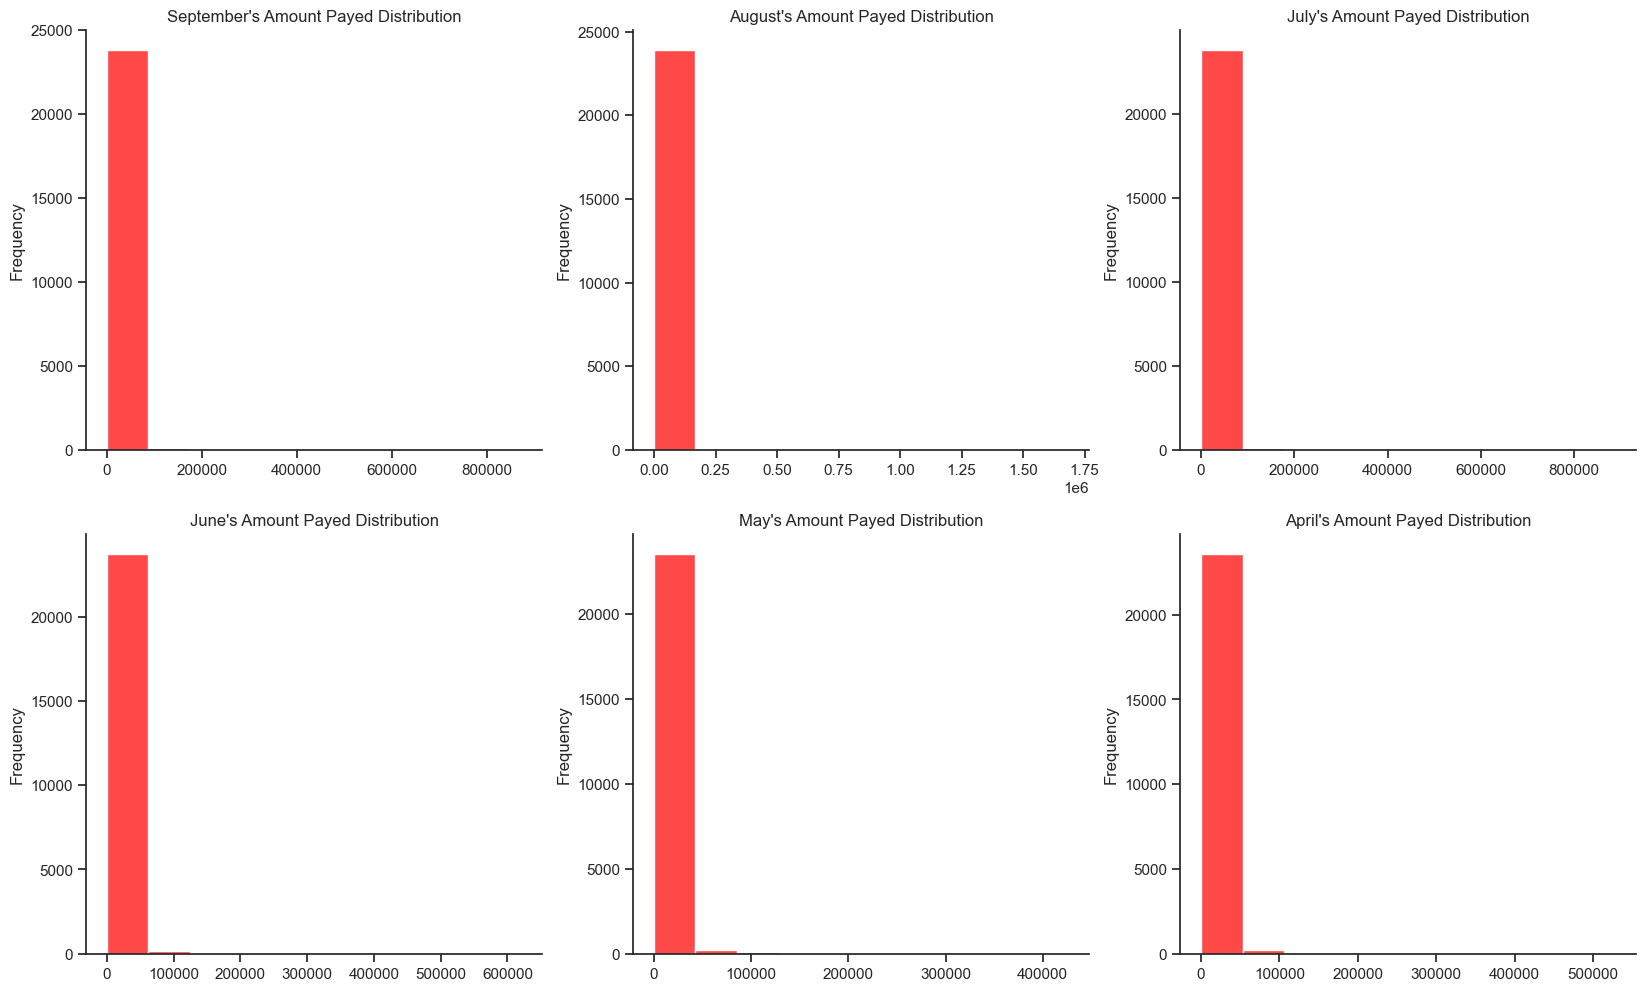

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,12))

h = df["pay_amt1"].plot(kind="hist", ax=axes[0][0])
h.set_title("September's Amount Payed Distribution")

h = df["pay_amt2"].plot(kind="hist", ax=axes[0][1])
h.set_title("August's Amount Payed Distribution")

h = df["pay_amt3"].plot(kind="hist", ax=axes[0][2])
h.set_title("July's Amount Payed Distribution")

h = df["pay_amt4"].plot(kind="hist", ax=axes[1][0])
h.set_title("June's Amount Payed Distribution")

h = df["pay_amt5"].plot(kind="hist", ax=axes[1][1])
h.set_title("May's Amount Payed Distribution")

h = df["pay_amt6"].plot(kind="hist", ax=axes[1][2])
h.set_title("April's Amount Payed Distribution")


print(f"Number of customers with bill statement equal to the payed amount (September): {len(df[df['bill_amt1'] == df['pay_amt1']])}")
print(f"Number of customers with bill statement equal to the payed amount (August): {len(df[df['bill_amt2'] == df['pay_amt2']])}")
print(f"Number of customers with bill statement equal to the payed amount (July): {len(df[df['bill_amt3'] == df['pay_amt3']])}")
print(f"Number of customers with bill statement equal to the payed amount (June): {len(df[df['bill_amt4'] == df['pay_amt4']])}")
print(f"Number of customers with bill statement equal to the payed amount (May): {len(df[df['bill_amt5'] == df['pay_amt5']])}")
print(f"Number of customers with bill statement equal to the payed amount (April): {len(df[df['bill_amt6'] == df['pay_amt6']])}")

#### Limit bal x Target

target                0     1
limit_balance_bin            
(0, 150000]        9540  3600
(150000, 300000]   5997  1218
(300000, 450000]   2271   381
(450000, 600000]    811   101
(600000, 700000]     40     2
(700000, 850000]     16     3

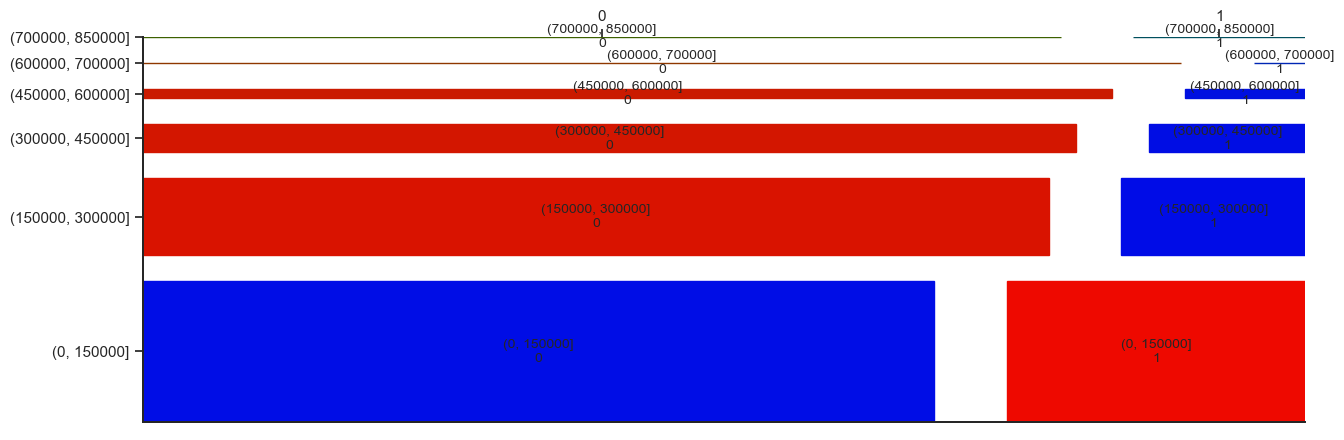

In [33]:
crosstable = pd.crosstab(df["limit_balance_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

Outliers:

In [34]:
out_cut, limit_bal_outliers = outlier_iqr(df, "limit_bal")

Potential outliers: 0.538% of dataset rows
129 cases below or above 1.5 IQR from 1Q/3Q


Text(0.5, 1.0, 'Limit Balance Distribution by Default Payment (Only Outliers)')

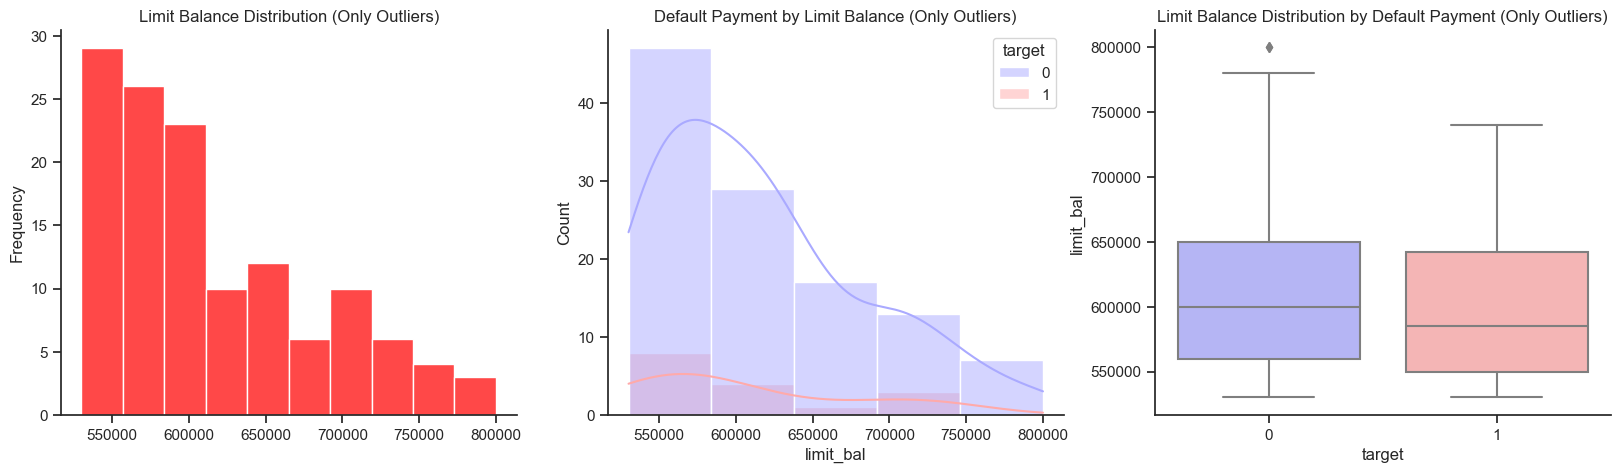

In [35]:
# The limit balance of customers ranges from 10000 to 800000:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

h = limit_bal_outliers["limit_bal"].plot(kind="hist", ax=axes[0])
h.set_title("Limit Balance Distribution (Only Outliers)")

h = sns.histplot(data=limit_bal_outliers, x="limit_bal", hue="target", kde=True, bins=5, palette="bwr", ax=axes[1])
h.set_title("Default Payment by Limit Balance (Only Outliers)")

h = sns.boxplot(data=limit_bal_outliers, x="target", y="limit_bal", ax=axes[2], palette="bwr")
h.set_title("Limit Balance Distribution by Default Payment (Only Outliers)")

target              0  1
limit_balance_bin       
(0, 550000]        23  6
(550000, 700000]   74  7
(700000, 850000]   16  3

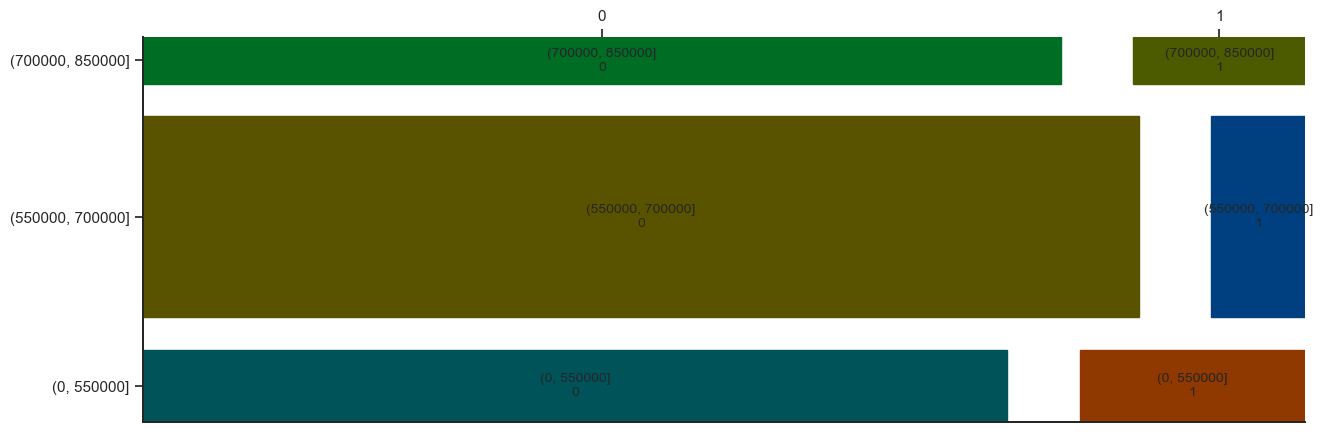

In [36]:
# bins = [0, 550000, 600000, 650000, 700000, 750000, 800000, 850000]
bins = [0, 550000, 700000, 850000]

limit_bal_outliers['limit_balance_bin'] = pd.cut(limit_bal_outliers['limit_bal'], bins)

crosstable = pd.crosstab(limit_bal_outliers["limit_balance_bin"], limit_bal_outliers["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Pay_X x Target

target                      0     1
pay_1                              
1 month delay            1960  1001
2 months delay            664  1467
3 months delay             57   200
4 months delay             21    41
5 months delay              9    10
6 months delay              3     5
7 months delay              2     5
8 months delay              7    11
No consumption           1902   293
Paid in full             3796   758
Revolving credit usage  10254  1514

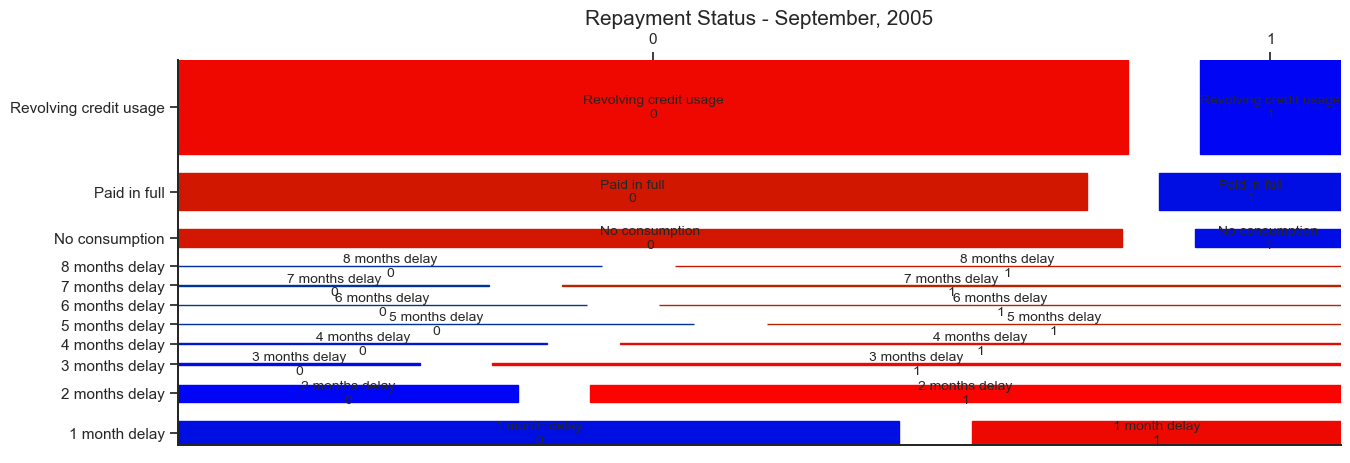

In [37]:
crosstable = pd.crosstab(df["pay_1"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

ax.set_title("Repayment Status - September, 2005", fontsize=15)
display(crosstable)

target                      0     1
pay_2                              
1 month delay              17     3
2 months delay           1391  1751
3 months delay             96   166
4 months delay             42    42
5 months delay              7    12
6 months delay              3     7
7 months delay              7    12
8 months delay              1     0
No consumption           2471   552
Paid in full             4080   759
Revolving credit usage  10560  2001

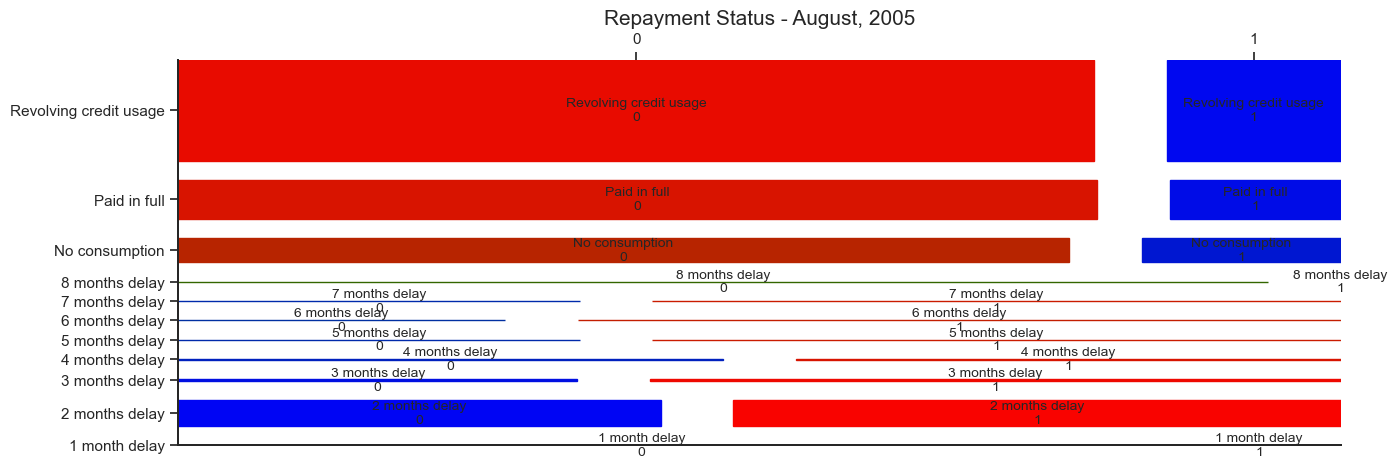

In [38]:
crosstable = pd.crosstab(df["pay_2"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

ax.set_title("Repayment Status - August, 2005", fontsize=15)
display(crosstable)

target                      0     1
pay_3                              
1 month delay               3     1
2 months delay           1474  1580
3 months delay             82   109
4 months delay             22    36
5 months delay              7     9
6 months delay              8    14
7 months delay              5    16
8 months delay              1     2
No consumption           2646   600
Paid in full             4035   735
Revolving credit usage  10392  2203

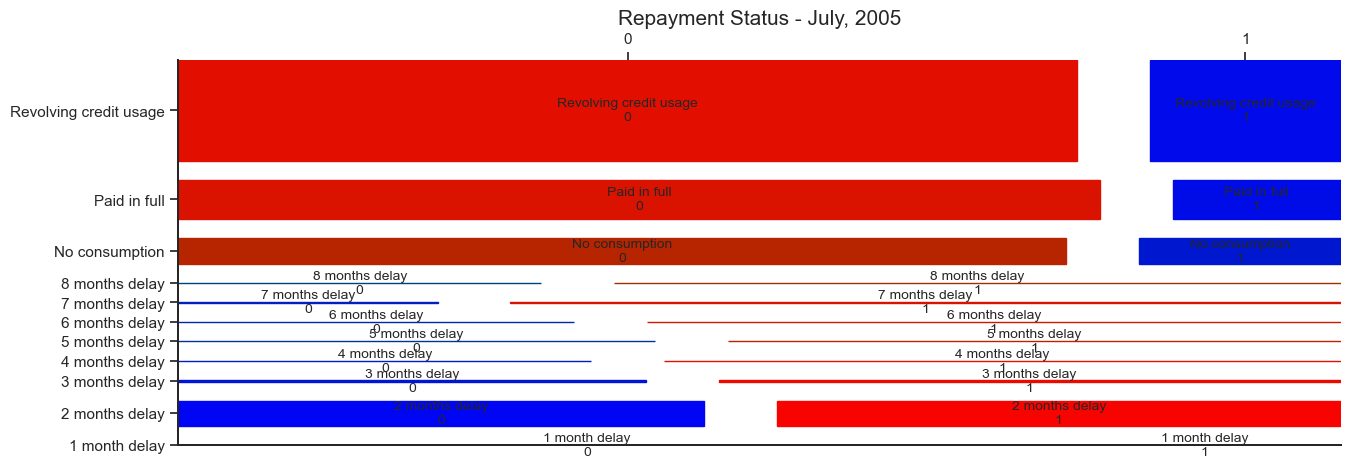

In [39]:
crosstable = pd.crosstab(df["pay_3"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

ax.set_title("Repayment Status - July, 2005", fontsize=15)
display(crosstable)

target                      0     1
pay_4                              
1 month delay               1     1
2 months delay           1199  1336
3 months delay             58    86
4 months delay             18    36
5 months delay             13    17
6 months delay              2     1
7 months delay              9    39
8 months delay              1     1
No consumption           2806   650
Paid in full             3825   733
Revolving credit usage  10743  2405

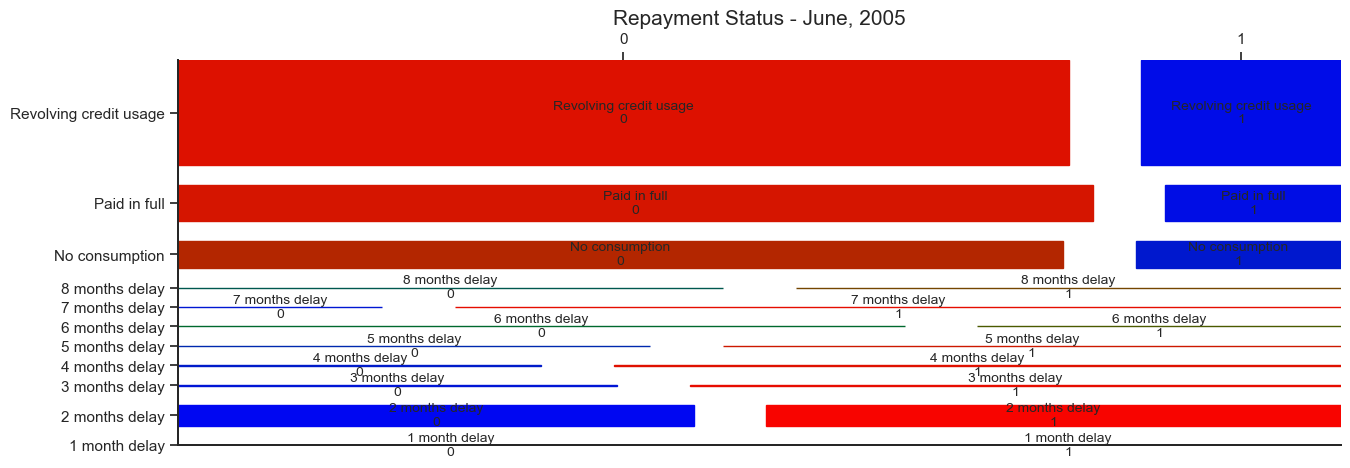

In [40]:
crosstable = pd.crosstab(df["pay_4"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

ax.set_title("Repayment Status - June, 2005", fontsize=15)
display(crosstable)

target                      0     1
pay_5                              
2 months delay            969  1155
3 months delay             52    88
4 months delay             27    42
5 months delay              5     9
6 months delay              0     3
7 months delay             10    38
8 months delay              0     1
No consumption           2922   700
Paid in full             3718   724
Revolving credit usage  10972  2545

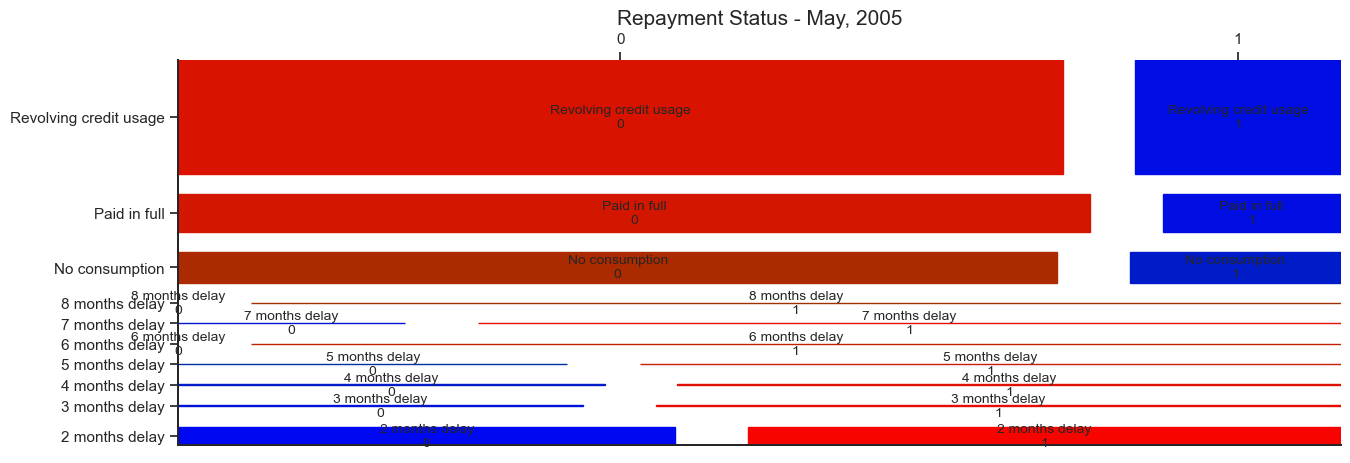

In [41]:
crosstable = pd.crosstab(df["pay_5"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

ax.set_title("Repayment Status - May, 2005", fontsize=15)
display(crosstable)

target                      0     1
pay_6                              
2 months delay           1090  1134
3 months delay             50    92
4 months delay             16    26
5 months delay              3     7
6 months delay              5    10
7 months delay              8    31
8 months delay              0     1
No consumption           3121   771
Paid in full             3811   783
Revolving credit usage  10571  2450

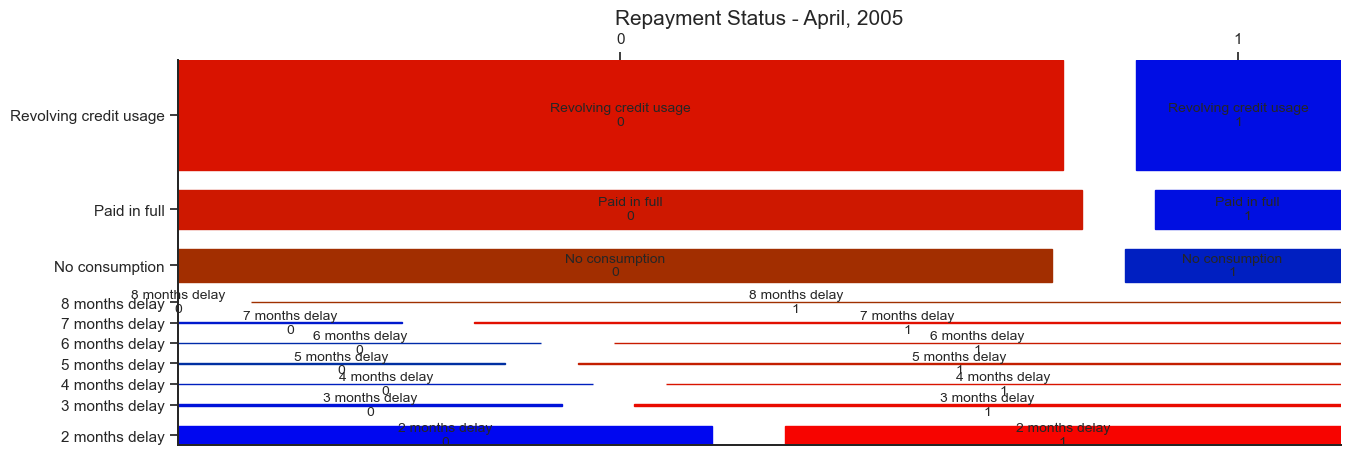

In [42]:
crosstable = pd.crosstab(df["pay_6"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

ax.set_title("Repayment Status - April, 2005", fontsize=15)
display(crosstable)

#### Pay_X x Limit bal

Text(0.5, 1.0, 'Limit Balance Distribution by Repayment Status - September, 2005')

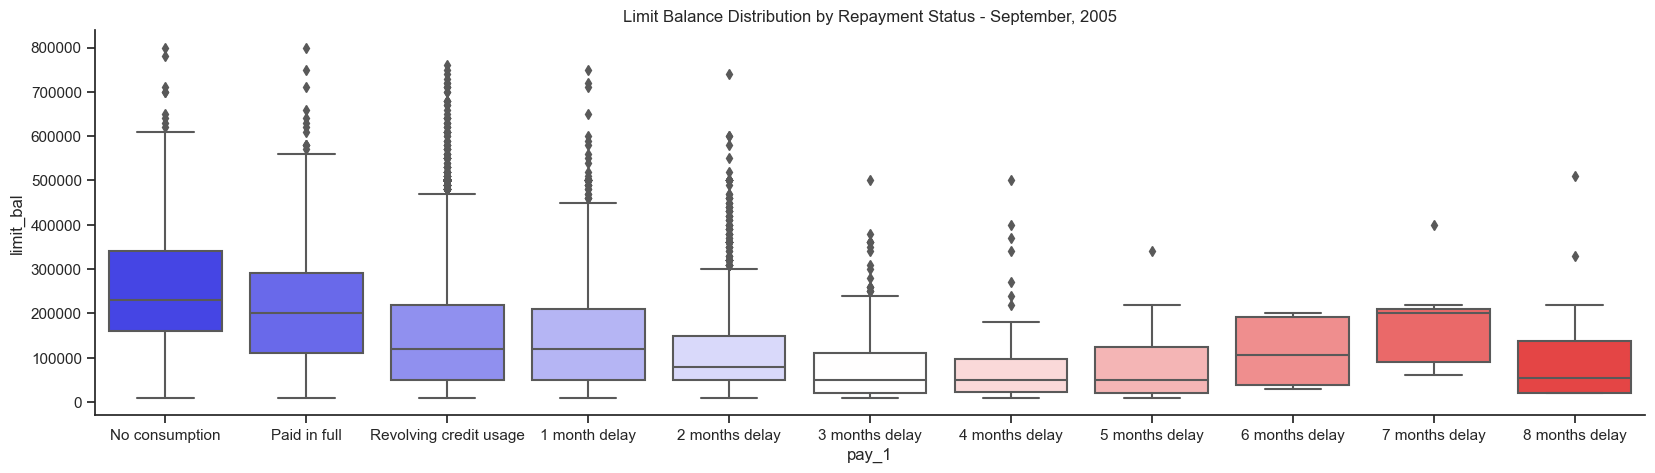

In [43]:
order = ["No consumption", "Paid in full", "Revolving credit usage", "1 month delay", "2 months delay", "3 months delay",
         "4 months delay", "5 months delay", "6 months delay", "7 months delay", "8 months delay"]

plt.figure(figsize=(20,5))

b = sns.boxplot(data=df, x="pay_1", y="limit_bal", palette="bwr", order=order)
b.set_title("Limit Balance Distribution by Repayment Status - September, 2005")

Text(0.5, 1.0, 'Limit Balance Distribution by Repayment Status - August, 2005')

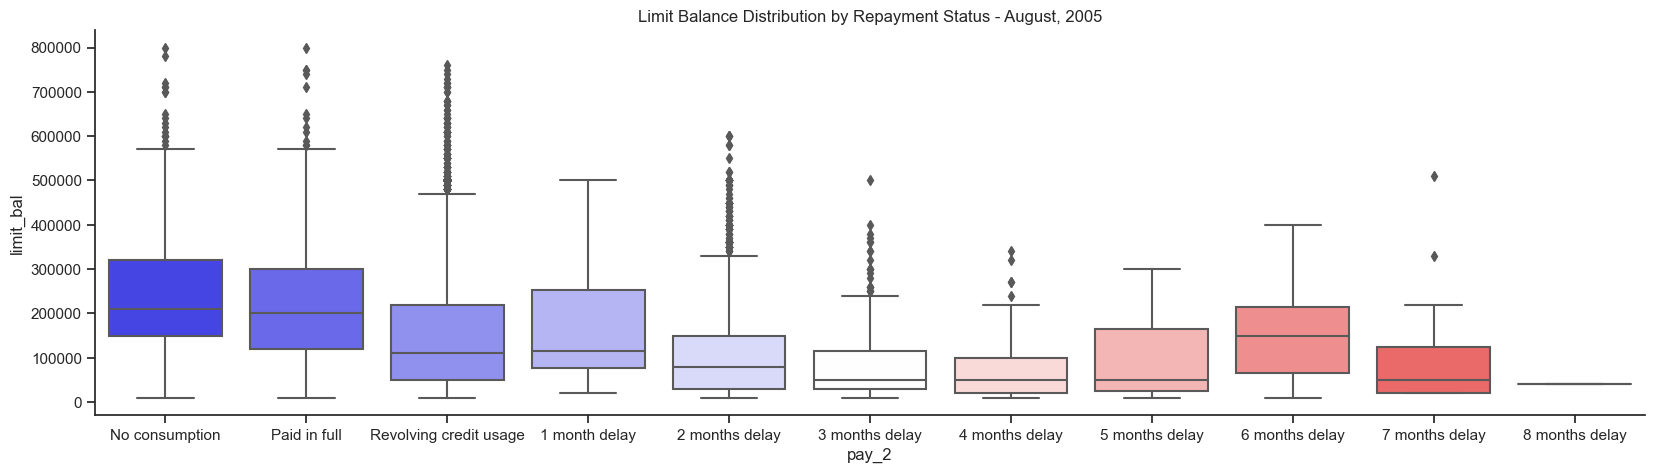

In [44]:
plt.figure(figsize=(20,5))

b = sns.boxplot(data=df, x="pay_2", y="limit_bal", palette="bwr", order=order)
b.set_title("Limit Balance Distribution by Repayment Status - August, 2005")

Text(0.5, 1.0, 'Limit Balance Distribution by Repayment Status - July, 2005')

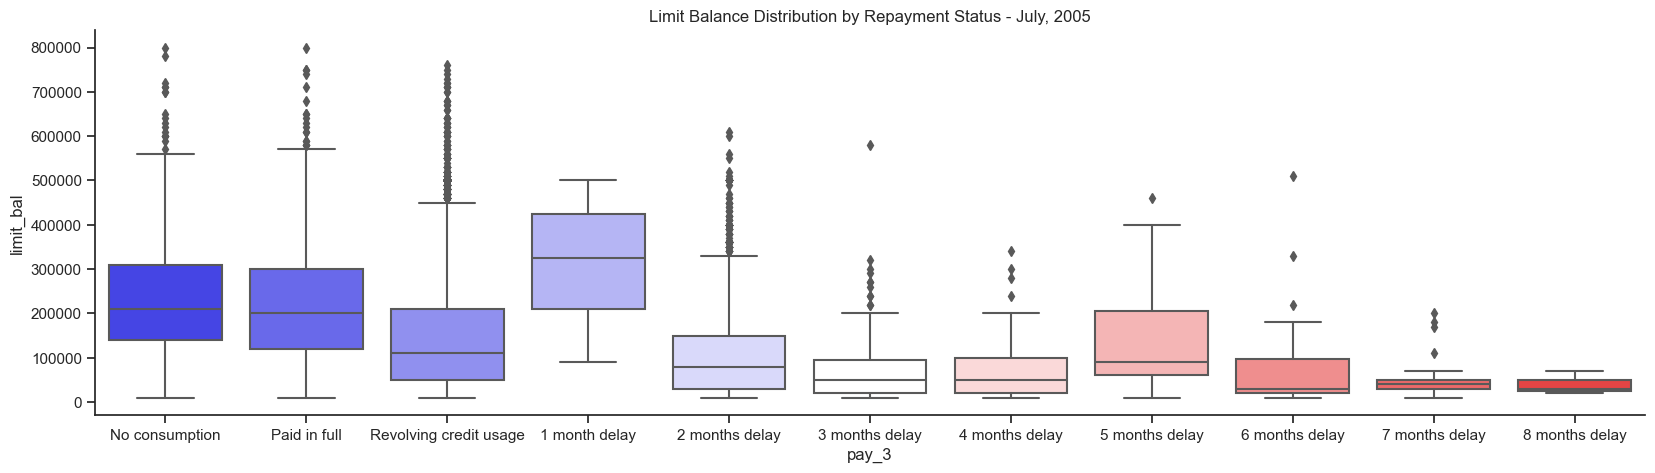

In [45]:
plt.figure(figsize=(20,5))

b = sns.boxplot(data=df, x="pay_3", y="limit_bal", palette="bwr", order=order)
b.set_title("Limit Balance Distribution by Repayment Status - July, 2005")

Text(0.5, 1.0, 'Limit Balance Distribution by Repayment Status - June, 2005')

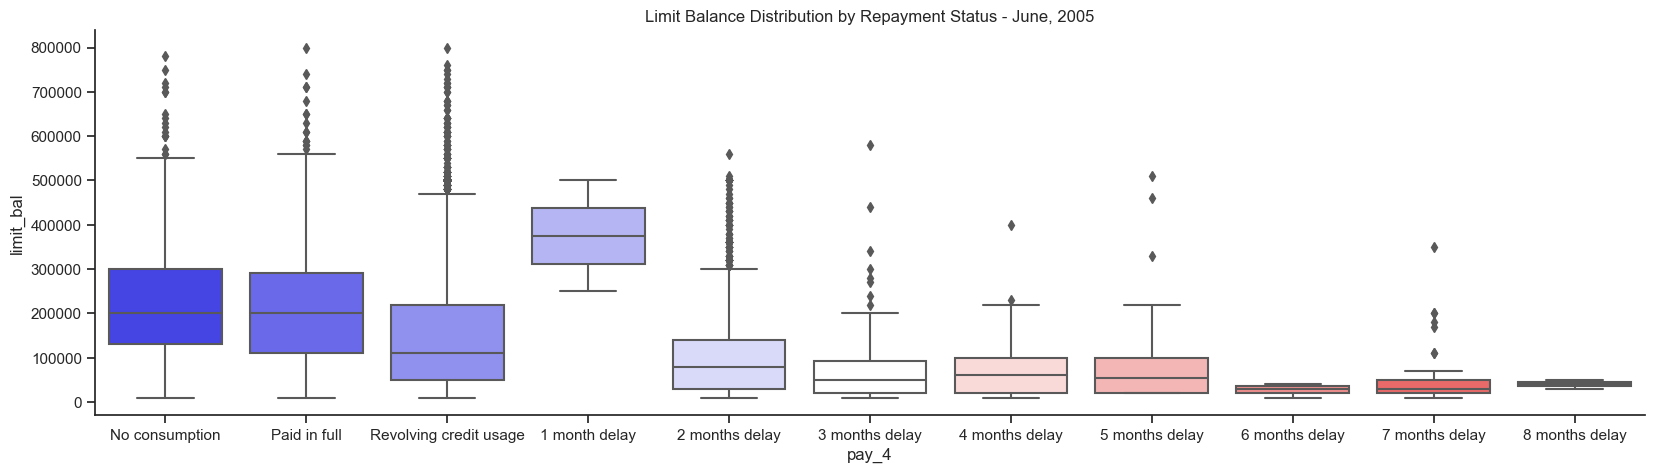

In [46]:
plt.figure(figsize=(20,5))

b = sns.boxplot(data=df, x="pay_4", y="limit_bal", palette="bwr", order=order)
b.set_title("Limit Balance Distribution by Repayment Status - June, 2005")

Text(0.5, 1.0, 'Limit Balance Distribution by Repayment Status - May, 2005')

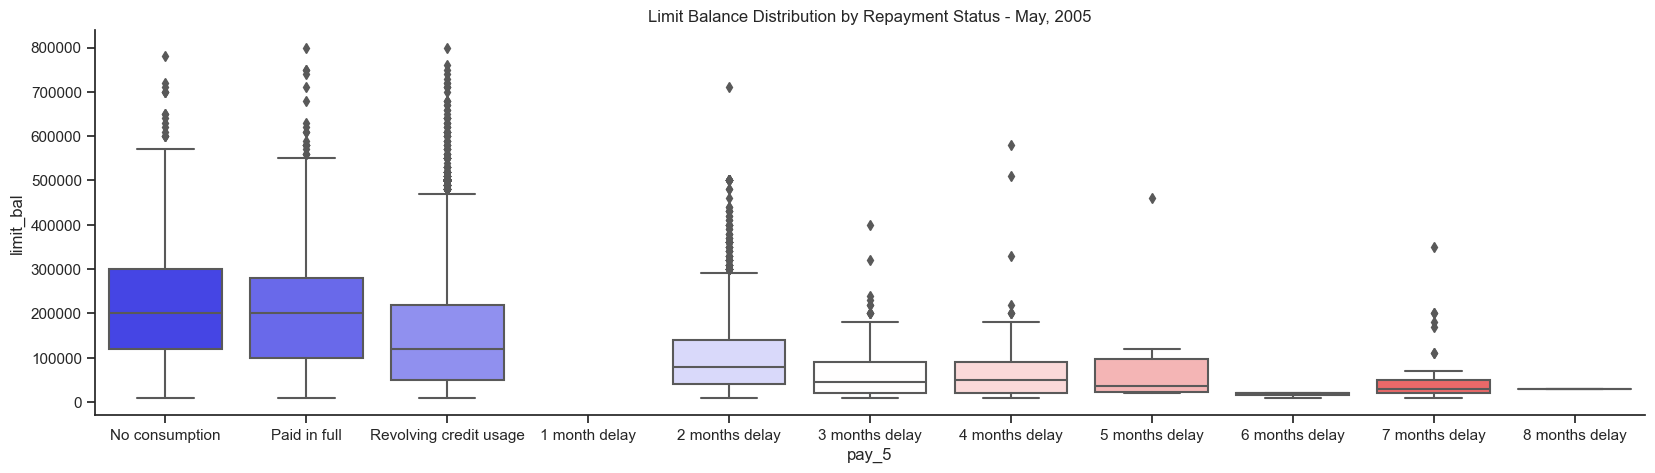

In [47]:
plt.figure(figsize=(20,5))

b = sns.boxplot(data=df, x="pay_5", y="limit_bal", palette="bwr", order=order)
b.set_title("Limit Balance Distribution by Repayment Status - May, 2005")

Text(0.5, 1.0, 'Limit Balance Distribution by Repayment Status - April, 2005')

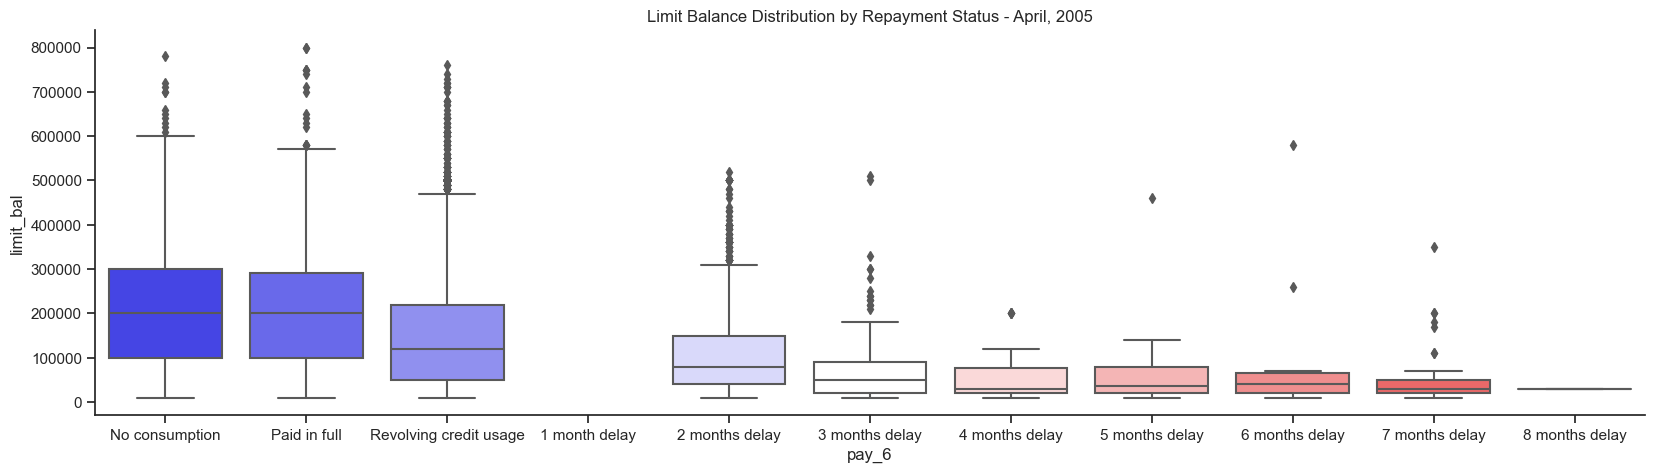

In [48]:
plt.figure(figsize=(20,5))

b = sns.boxplot(data=df, x="pay_6", y="limit_bal", palette="bwr", order=order)
b.set_title("Limit Balance Distribution by Repayment Status - April, 2005")

#### Bill_amtX x Target

Text(0.5, 1.0, "Default Payment by April's Bill Statement")

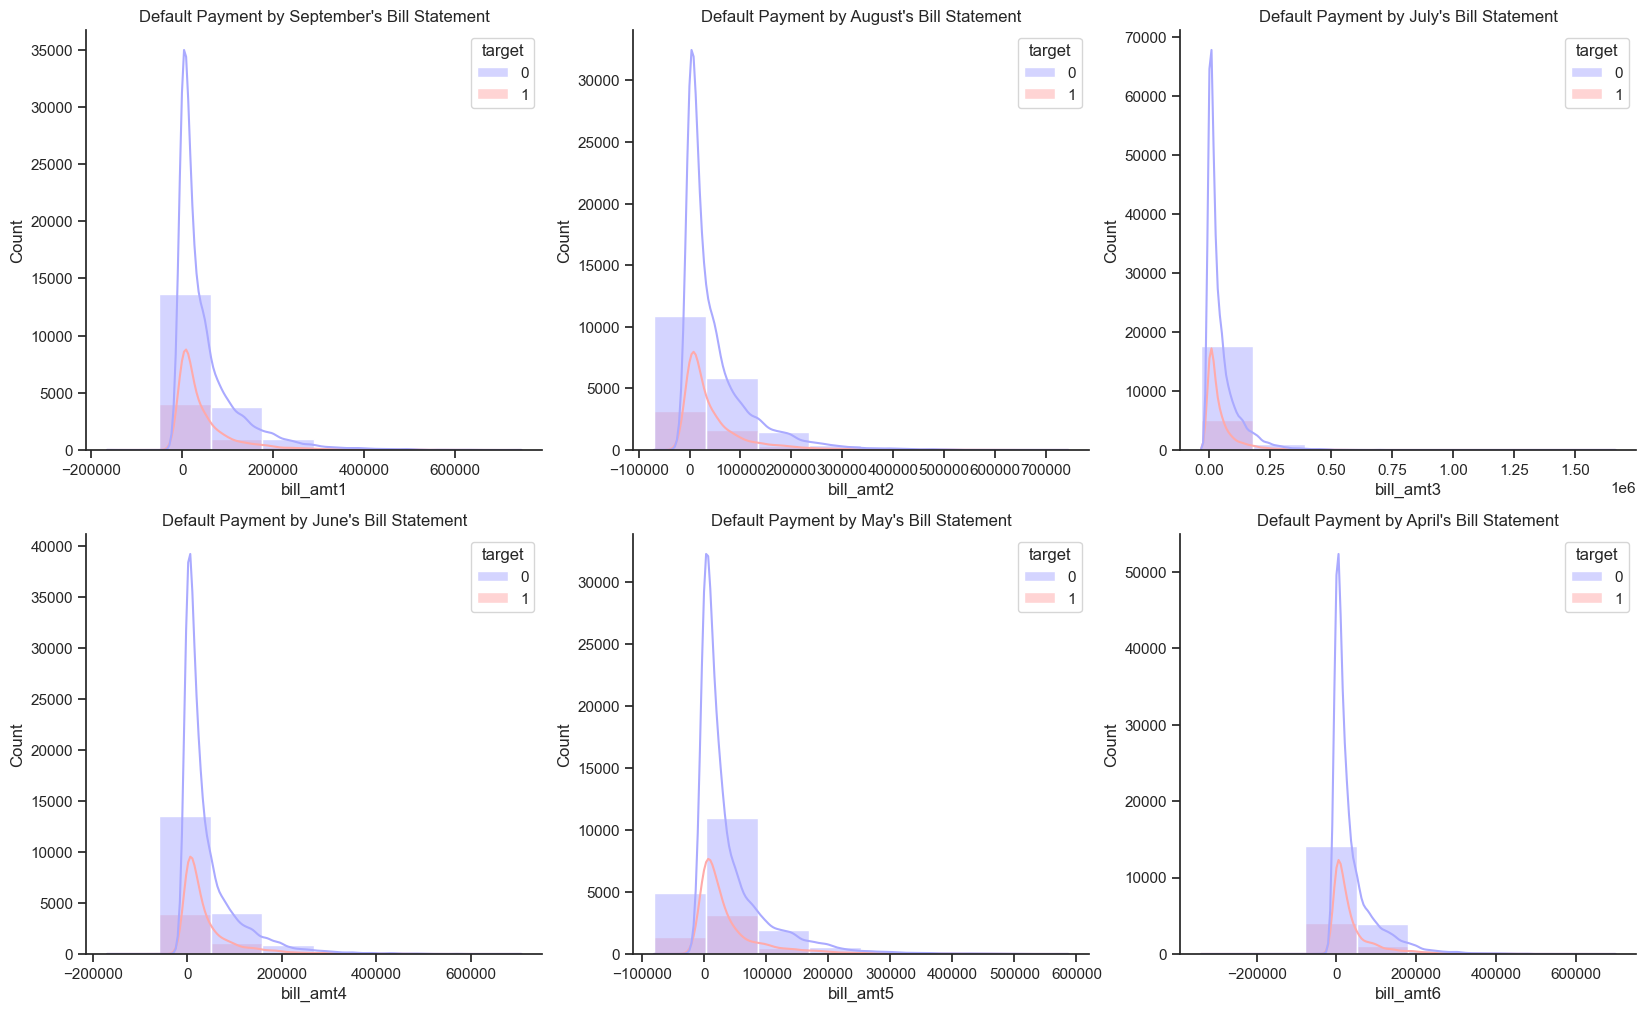

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,12))

h = sns.histplot(data=df, x="bill_amt1", hue="target", kde=True, bins=8, palette="bwr", ax=axes[0][0])
h.set_title("Default Payment by September's Bill Statement")

h = sns.histplot(data=df, x="bill_amt2", hue="target", kde=True, bins=8, palette="bwr", ax=axes[0][1])
h.set_title("Default Payment by August's Bill Statement")

h = sns.histplot(data=df, x="bill_amt3", hue="target", kde=True, bins=8, palette="bwr", ax=axes[0][2])
h.set_title("Default Payment by July's Bill Statement")

h = sns.histplot(data=df, x="bill_amt4", hue="target", kde=True, bins=8, palette="bwr", ax=axes[1][0])
h.set_title("Default Payment by June's Bill Statement")

h = sns.histplot(data=df, x="bill_amt5", hue="target", kde=True, bins=8, palette="bwr", ax=axes[1][1])
h.set_title("Default Payment by May's Bill Statement")

h = sns.histplot(data=df, x="bill_amt6", hue="target", kde=True, bins=8, palette="bwr", ax=axes[1][2])
h.set_title("Default Payment by April's Bill Statement")

Text(0.5, 1.0, "April's Bill Statement Distribution by Default Payment")

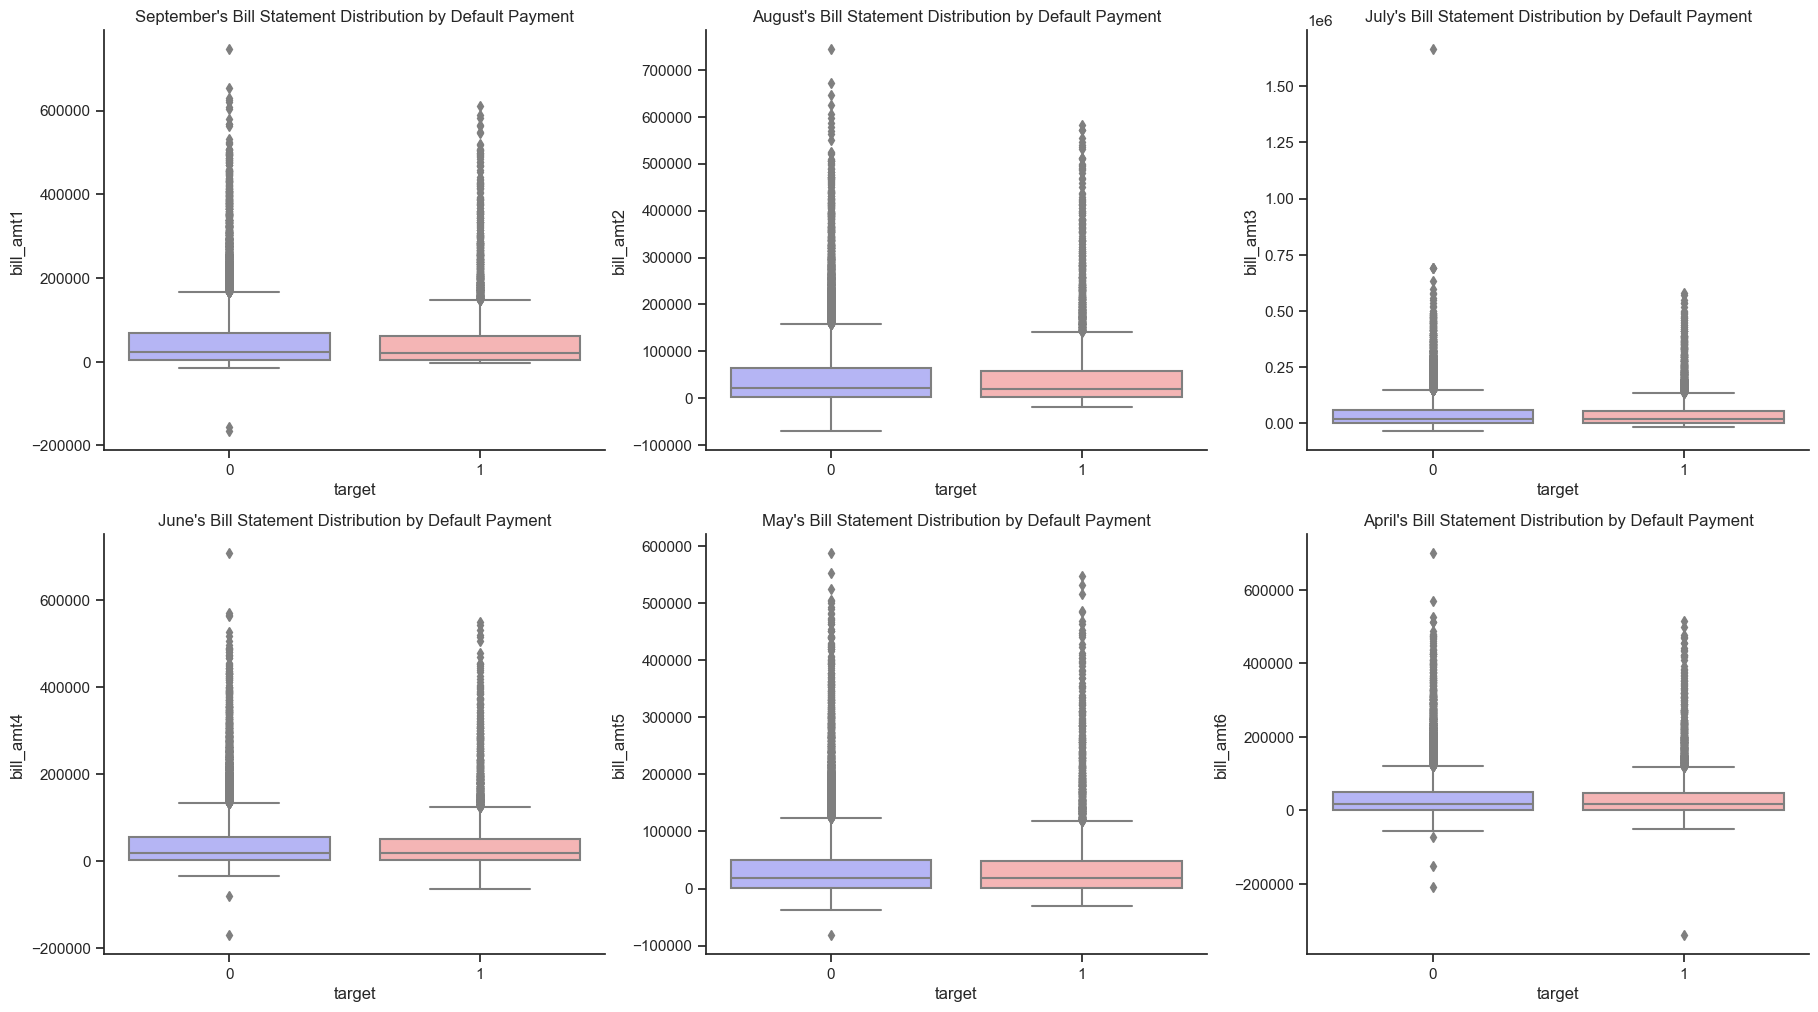

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22,12))

h = sns.boxplot(data=df, x="target", y="bill_amt1", palette="bwr", ax=axes[0][0])
h.set_title("September's Bill Statement Distribution by Default Payment")

h = sns.boxplot(data=df, x="target", y="bill_amt2", palette="bwr", ax=axes[0][1])
h.set_title("August's Bill Statement Distribution by Default Payment")

h = sns.boxplot(data=df, x="target", y="bill_amt3", palette="bwr", ax=axes[0][2])
h.set_title("July's Bill Statement Distribution by Default Payment")

h = sns.boxplot(data=df, x="target", y="bill_amt4", palette="bwr", ax=axes[1][0])
h.set_title("June's Bill Statement Distribution by Default Payment")

h = sns.boxplot(data=df, x="target", y="bill_amt5", palette="bwr", ax=axes[1][1])
h.set_title("May's Bill Statement Distribution by Default Payment")

h = sns.boxplot(data=df, x="target", y="bill_amt6", palette="bwr", ax=axes[1][2])
h.set_title("April's Bill Statement Distribution by Default Payment")


In [51]:
# Create a new variable by cutting the bill_amtX variable into intervals:
bins = [-np.Infinity, -50000, -25000, -10000, 0, 10000, 25000, 50000, 75000, 100000, np.Infinity]

df['bill_amt1_bin'] = pd.cut(df['bill_amt1'], bins)
df['bill_amt2_bin'] = pd.cut(df['bill_amt2'], bins)
df['bill_amt3_bin'] = pd.cut(df['bill_amt3'], bins)
df['bill_amt4_bin'] = pd.cut(df['bill_amt4'], bins)
df['bill_amt5_bin'] = pd.cut(df['bill_amt5'], bins)
df['bill_amt6_bin'] = pd.cut(df['bill_amt6'], bins)

target                   0     1
bill_amt1_bin                   
(-inf, -50000.0]         2     0
(-25000.0, -10000.0]     4     0
(-10000.0, 0.0]       1550   516
(0.0, 10000.0]        5186  1430
(10000.0, 25000.0]    2894   892
(25000.0, 50000.0]    3032   904
(50000.0, 75000.0]    1691   474
(75000.0, 100000.0]   1175   321
(100000.0, inf]       3141   768

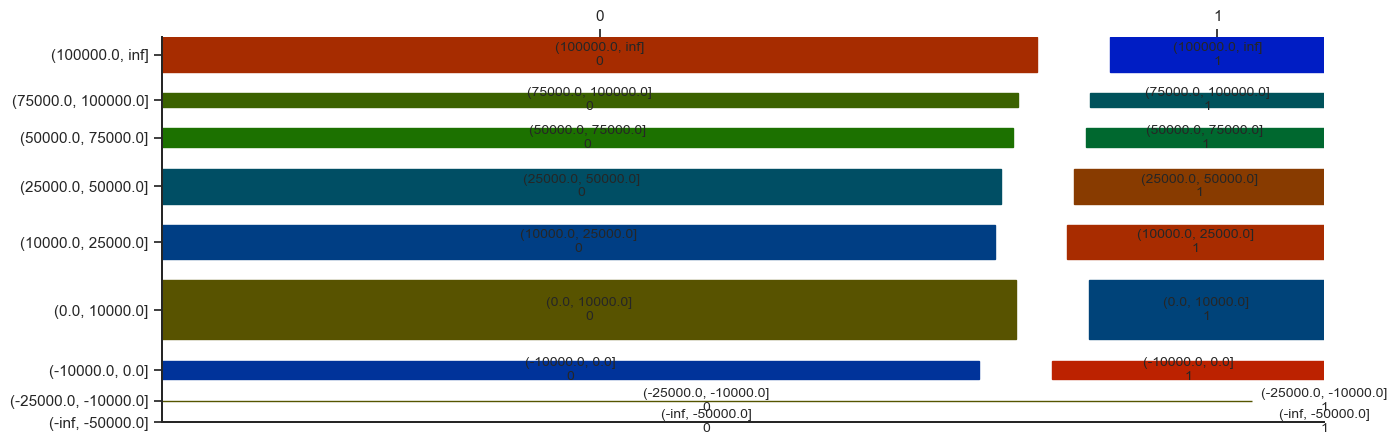

In [52]:
crosstable = pd.crosstab(df["bill_amt1_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                   0     1
bill_amt2_bin                   
(-inf, -50000.0]         2     0
(-50000.0, -25000.0]     3     0
(-25000.0, -10000.0]     6     1
(-10000.0, 0.0]       1929   594
(0.0, 10000.0]        5010  1328
(10000.0, 25000.0]    2894   930
(25000.0, 50000.0]    3031   919
(50000.0, 75000.0]    1703   465
(75000.0, 100000.0]   1127   322
(100000.0, inf]       2970   746

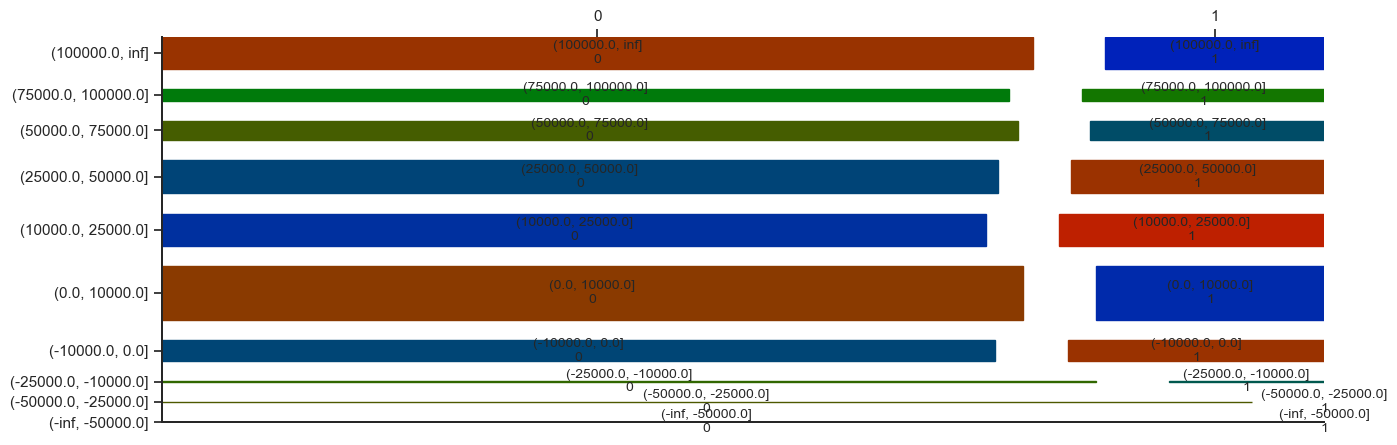

In [53]:
crosstable = pd.crosstab(df["bill_amt2_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                   0     1
bill_amt3_bin                   
(-50000.0, -25000.0]     1     0
(-25000.0, -10000.0]     9     2
(-10000.0, 0.0]       2155   629
(0.0, 10000.0]        4899  1317
(10000.0, 25000.0]    3070   955
(25000.0, 50000.0]    3041   937
(50000.0, 75000.0]    1635   458
(75000.0, 100000.0]   1097   301
(100000.0, inf]       2768   706

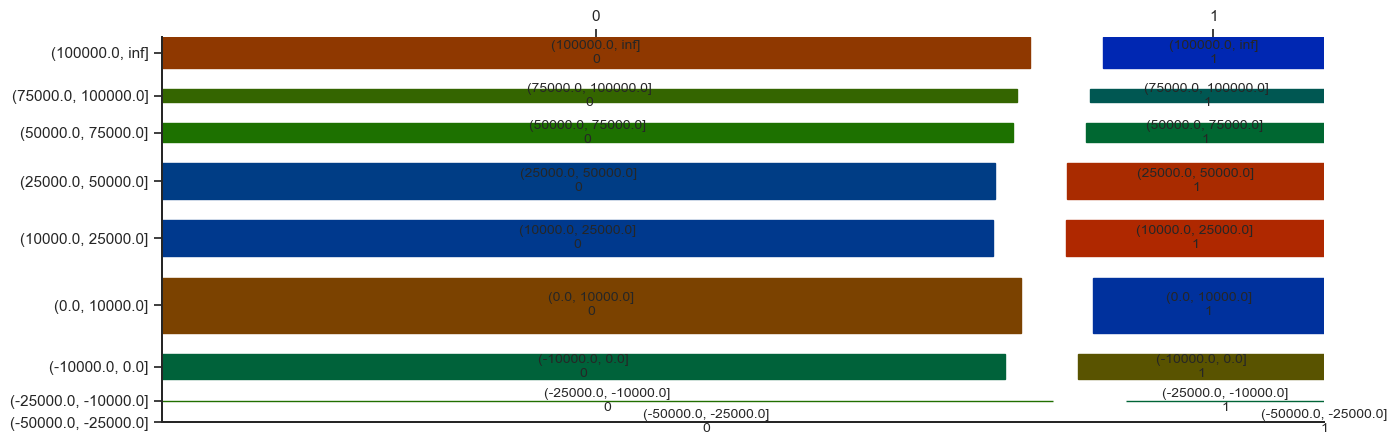

In [54]:
crosstable = pd.crosstab(df["bill_amt3_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                   0     1
bill_amt4_bin                   
(-inf, -50000.0]         2     1
(-50000.0, -25000.0]     2     0
(-25000.0, -10000.0]     4     2
(-10000.0, 0.0]       2359   699
(0.0, 10000.0]        4931  1278
(10000.0, 25000.0]    3286  1057
(25000.0, 50000.0]    3077   910
(50000.0, 75000.0]    1480   417
(75000.0, 100000.0]   1044   299
(100000.0, inf]       2490   642

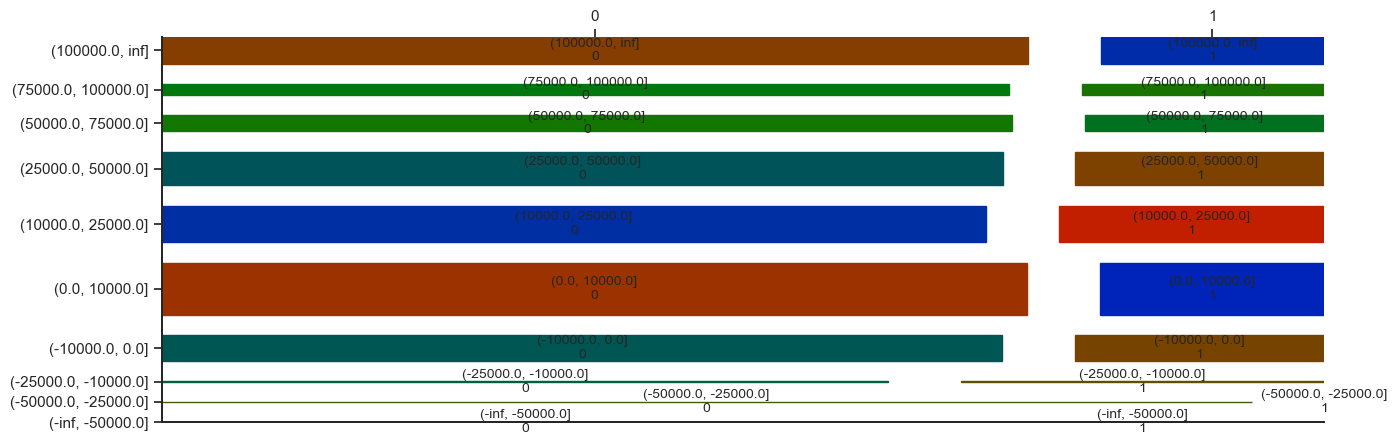

In [55]:
crosstable = pd.crosstab(df["bill_amt4_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                   0     1
bill_amt5_bin                   
(-inf, -50000.0]         1     0
(-50000.0, -25000.0]     3     1
(-25000.0, -10000.0]     6     2
(-10000.0, 0.0]       2529   772
(0.0, 10000.0]        5106  1289
(10000.0, 25000.0]    3330  1062
(25000.0, 50000.0]    2965   930
(50000.0, 75000.0]    1438   362
(75000.0, 100000.0]   1029   271
(100000.0, inf]       2268   616

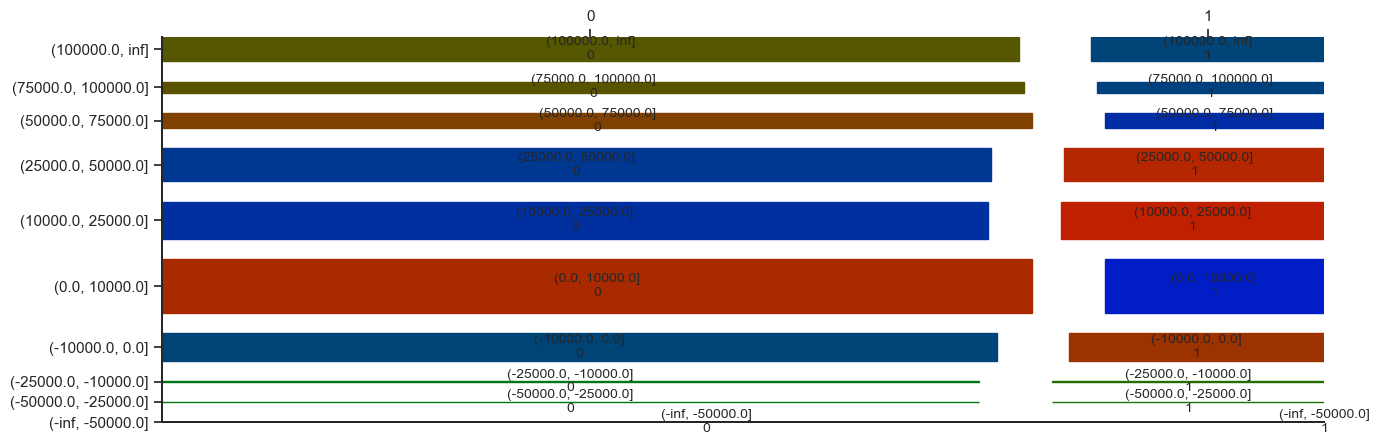

In [56]:
crosstable = pd.crosstab(df["bill_amt5_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                   0     1
bill_amt6_bin                   
(-inf, -50000.0]         5     2
(-50000.0, -25000.0]     5     0
(-25000.0, -10000.0]    15     2
(-10000.0, 0.0]       2901   858
(0.0, 10000.0]        5109  1277
(10000.0, 25000.0]    3151  1012
(25000.0, 50000.0]    2914   919
(50000.0, 75000.0]    1368   352
(75000.0, 100000.0]    992   288
(100000.0, inf]       2215   595

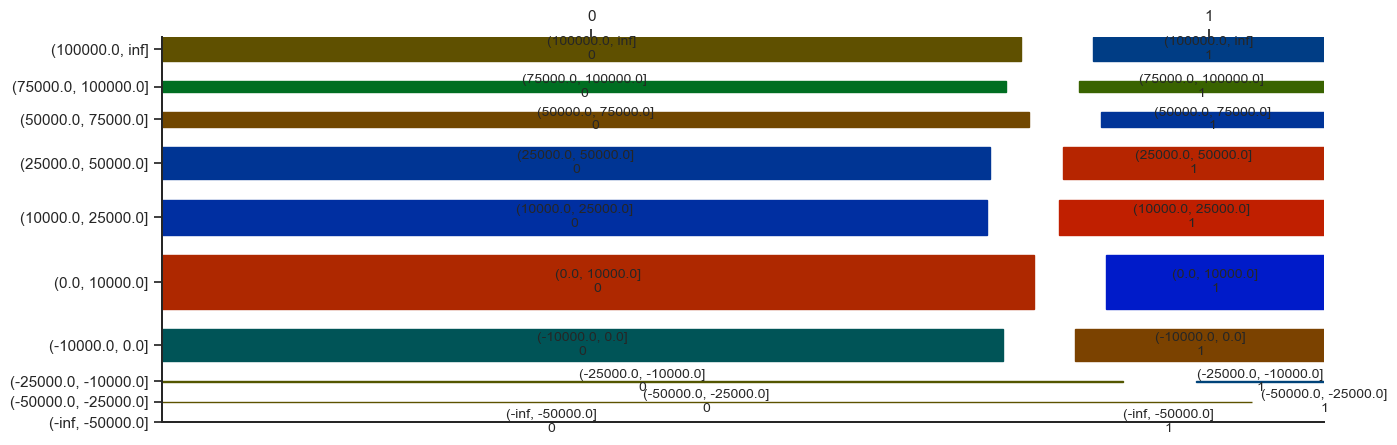

In [57]:
crosstable = pd.crosstab(df["bill_amt6_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Pay_amtX x Target

Text(0.5, 1.0, "April's Payment Amount Distribution by Default Payment")

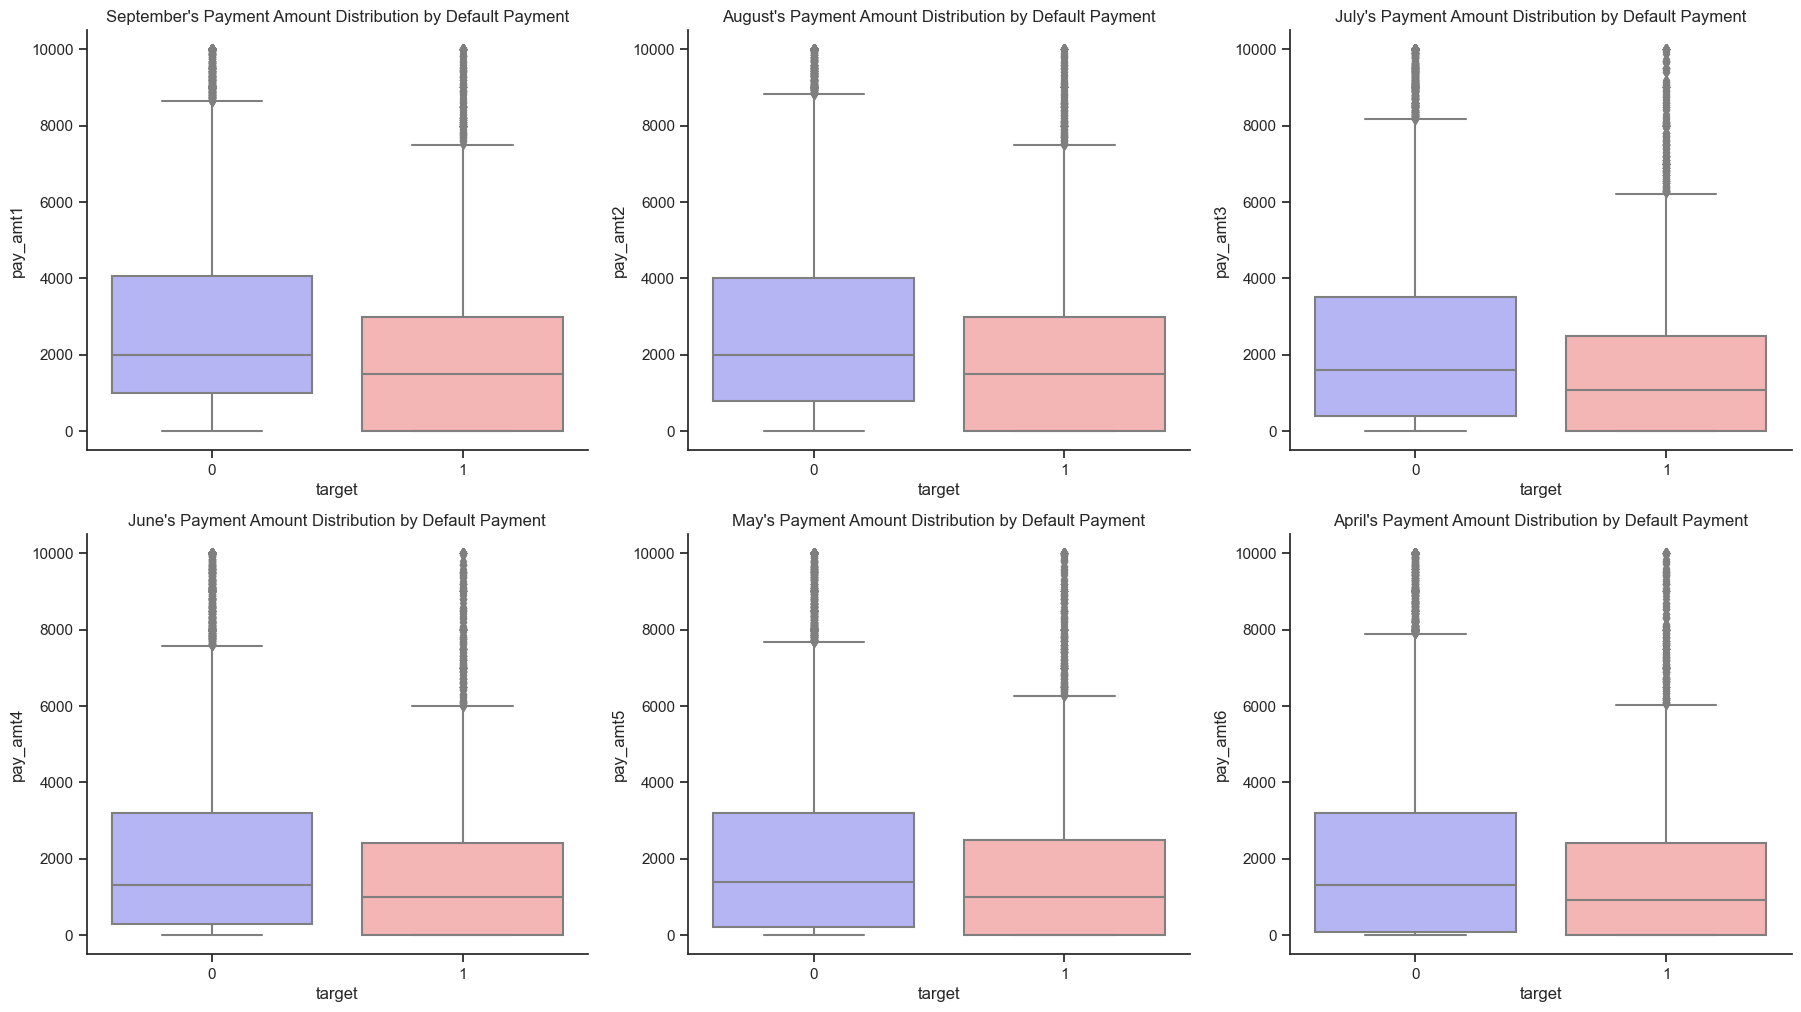

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22,12))

h = sns.boxplot(data=df[df["pay_amt1"] <= 10000], x="target", y="pay_amt1", palette="bwr", ax=axes[0][0])
h.set_title("September's Payment Amount Distribution by Default Payment")

h = sns.boxplot(data=df[df["pay_amt2"] <= 10000], x="target", y="pay_amt2", palette="bwr", ax=axes[0][1])
h.set_title("August's Payment Amount Distribution by Default Payment")

h = sns.boxplot(data=df[df["pay_amt3"] <= 10000], x="target", y="pay_amt3", palette="bwr", ax=axes[0][2])
h.set_title("July's Payment Amount Distribution by Default Payment")

h = sns.boxplot(data=df[df["pay_amt4"] <= 10000], x="target", y="pay_amt4", palette="bwr", ax=axes[1][0])
h.set_title("June's Payment Amount Distribution by Default Payment")

h = sns.boxplot(data=df[df["pay_amt5"] <= 10000], x="target", y="pay_amt5", palette="bwr", ax=axes[1][1])
h.set_title("May's Payment Amount Distribution by Default Payment")

h = sns.boxplot(data=df[df["pay_amt6"] <= 10000], x="target", y="pay_amt6", palette="bwr", ax=axes[1][2])
h.set_title("April's Payment Amount Distribution by Default Payment")

In [59]:
# Create a new variable by cutting the pay_amtX variable into intervals:
bins = [0, 1000, 2500, 5000, 7500, 10000, 100000, np.Infinity]

df['pay_amt1_bin'] = pd.cut(df['pay_amt1'], bins)
df['pay_amt2_bin'] = pd.cut(df['pay_amt2'], bins)
df['pay_amt3_bin'] = pd.cut(df['pay_amt3'], bins)
df['pay_amt4_bin'] = pd.cut(df['pay_amt4'], bins)
df['pay_amt5_bin'] = pd.cut(df['pay_amt5'], bins)
df['pay_amt6_bin'] = pd.cut(df['pay_amt6'], bins)

target                  0     1
pay_amt1_bin                   
(0.0, 1000.0]        1588   466
(1000.0, 2500.0]     5315  1502
(2500.0, 5000.0]     3902   992
(5000.0, 7500.0]     1847   329
(7500.0, 10000.0]    1094   190
(10000.0, 100000.0]  2142   302
(100000.0, inf]       107    11

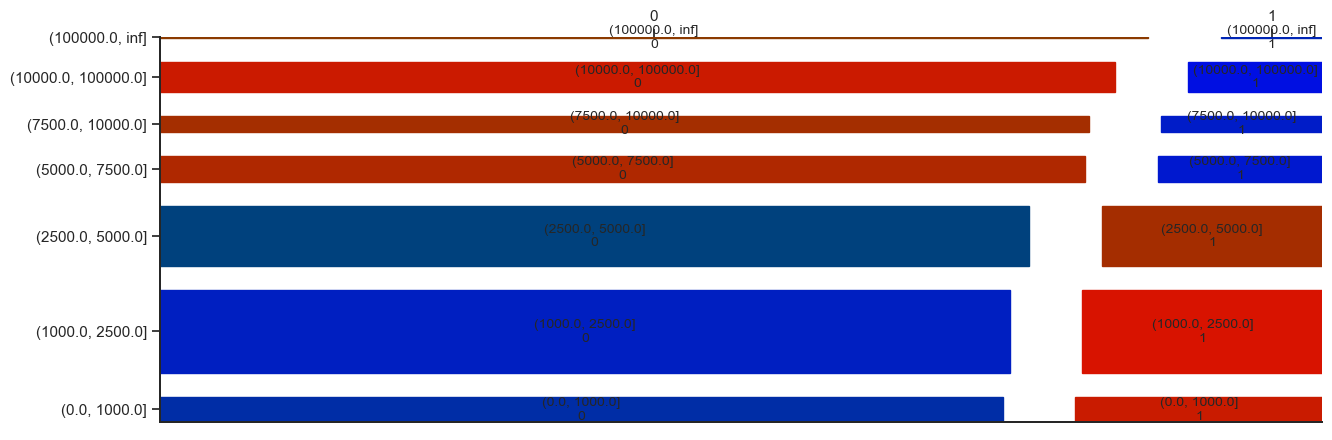

In [60]:
crosstable = pd.crosstab(df["pay_amt1_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                  0     1
pay_amt2_bin                   
(0.0, 1000.0]        1770   560
(1000.0, 2500.0]     5269  1539
(2500.0, 5000.0]     3811   978
(5000.0, 7500.0]     1708   309
(7500.0, 10000.0]     972   204
(10000.0, 100000.0]  2118   277
(100000.0, inf]       142    15

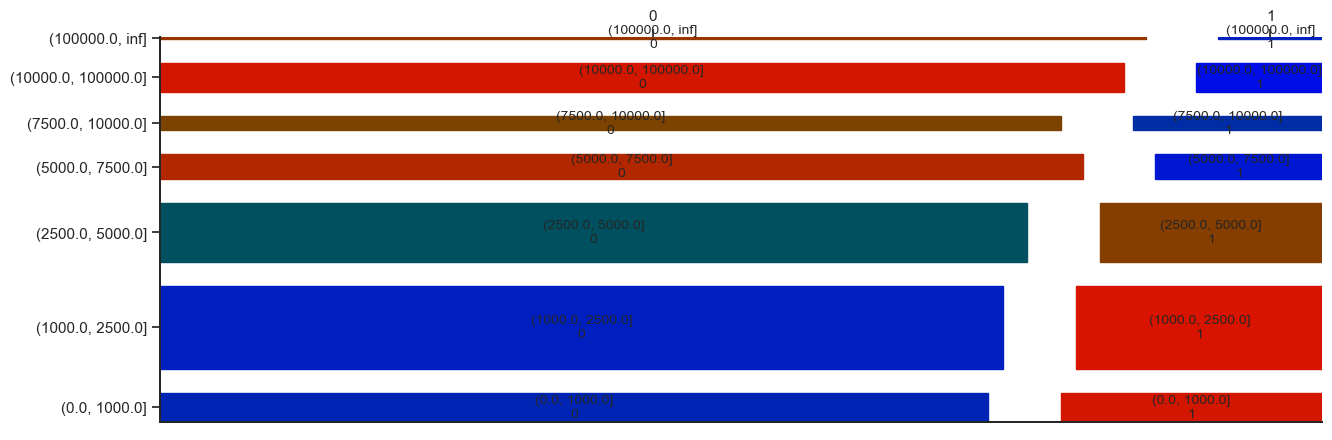

In [61]:
crosstable = pd.crosstab(df["pay_amt2_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                  0     1
pay_amt3_bin                   
(0.0, 1000.0]        2950   888
(1000.0, 2500.0]     4693  1320
(2500.0, 5000.0]     3448   802
(5000.0, 7500.0]     1471   300
(7500.0, 10000.0]     897   146
(10000.0, 100000.0]  1872   287
(100000.0, inf]       121    17

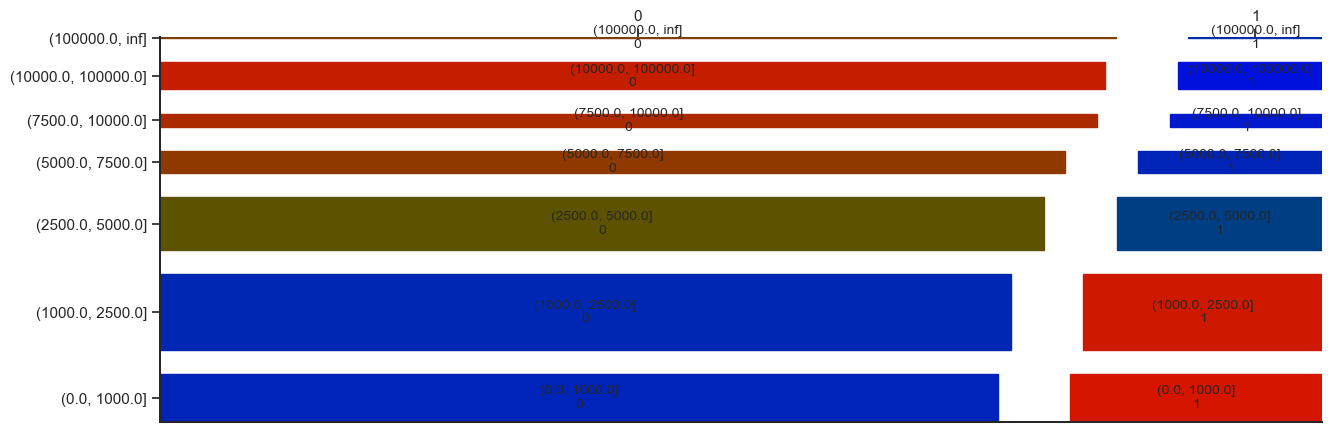

In [62]:
crosstable = pd.crosstab(df["pay_amt3_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                  0     1
pay_amt4_bin                   
(0.0, 1000.0]        3936  1164
(1000.0, 2500.0]     3868  1086
(2500.0, 5000.0]     3411   756
(5000.0, 7500.0]     1335   280
(7500.0, 10000.0]     807   141
(10000.0, 100000.0]  1652   281
(100000.0, inf]       102    11

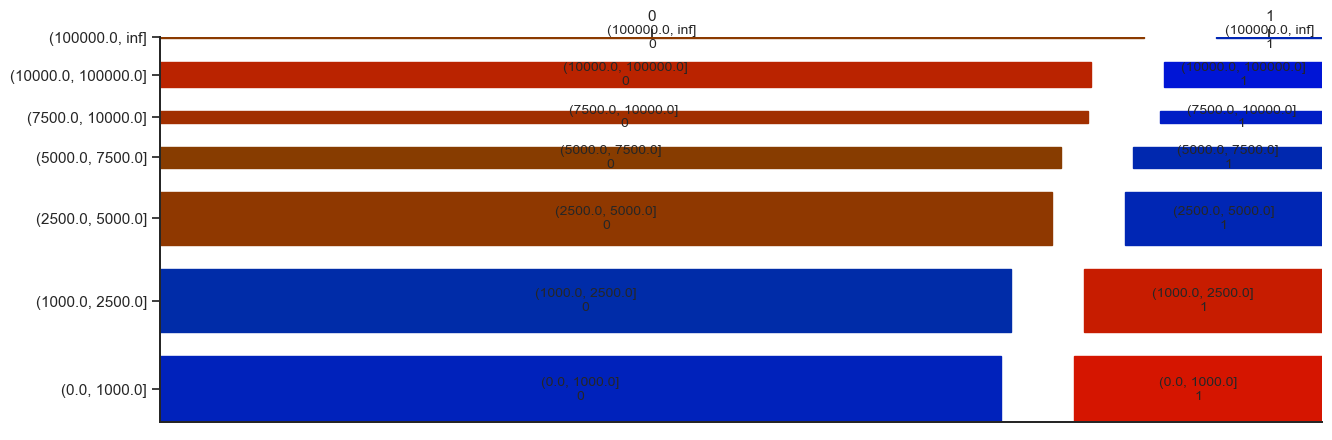

In [63]:
crosstable = pd.crosstab(df["pay_amt4_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                  0     1
pay_amt5_bin                   
(0.0, 1000.0]        3667  1106
(1000.0, 2500.0]     3897  1131
(2500.0, 5000.0]     3381   768
(5000.0, 7500.0]     1367   278
(7500.0, 10000.0]     767   175
(10000.0, 100000.0]  1675   249
(100000.0, inf]       103    18

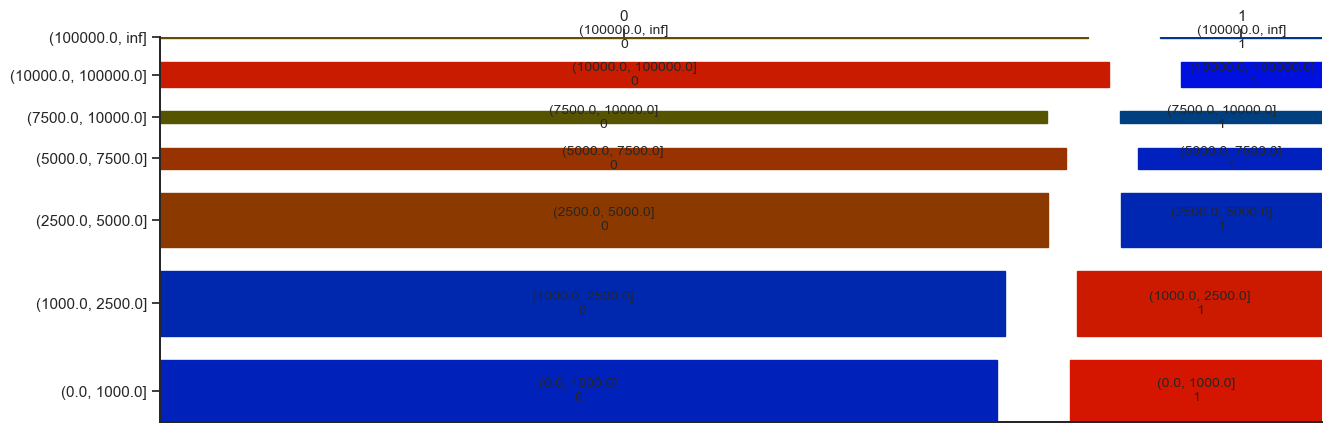

In [64]:
crosstable = pd.crosstab(df["pay_amt5_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                  0     1
pay_amt6_bin                   
(0.0, 1000.0]        3570  1108
(1000.0, 2500.0]     3676  1070
(2500.0, 5000.0]     3452   805
(5000.0, 7500.0]     1285   250
(7500.0, 10000.0]     800   141
(10000.0, 100000.0]  1631   243
(100000.0, inf]       163    21

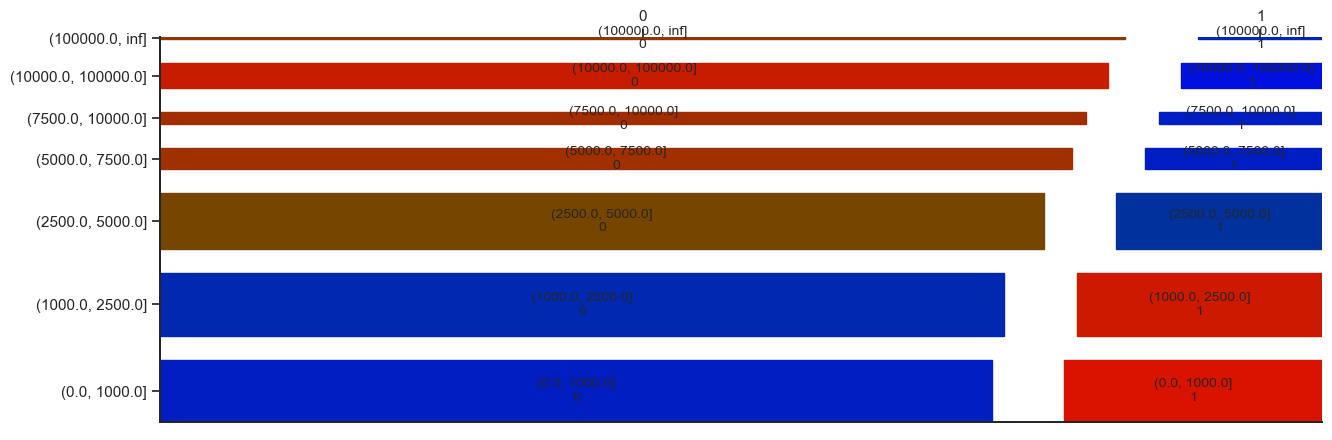

In [65]:
crosstable = pd.crosstab(df["pay_amt6_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

Outliers:


In [66]:
out_cut, pay_amt1_outliers = outlier_iqr(df, "pay_amt1")
out_cut, pay_amt2_outliers = outlier_iqr(df, "pay_amt2")
out_cut, pay_amt3_outliers = outlier_iqr(df, "pay_amt3")
out_cut, pay_amt4_outliers = outlier_iqr(df, "pay_amt4")
out_cut, pay_amt5_outliers = outlier_iqr(df, "pay_amt5")
out_cut, pay_amt6_outliers = outlier_iqr(df, "pay_amt6")

Potential outliers: 9.058% of dataset rows
2172 cases below or above 1.5 IQR from 1Q/3Q
Potential outliers: 8.924% of dataset rows
2140 cases below or above 1.5 IQR from 1Q/3Q
Potential outliers: 8.657% of dataset rows
2076 cases below or above 1.5 IQR from 1Q/3Q
Potential outliers: 9.858% of dataset rows
2364 cases below or above 1.5 IQR from 1Q/3Q
Potential outliers: 9.766% of dataset rows
2342 cases below or above 1.5 IQR from 1Q/3Q
Potential outliers: 9.829% of dataset rows
2357 cases below or above 1.5 IQR from 1Q/3Q


In [67]:
outliers = pd.concat([pay_amt1_outliers, pay_amt2_outliers, pay_amt3_outliers, 
                      pay_amt4_outliers, pay_amt5_outliers, pay_amt6_outliers], ignore_index=True)

outliers.drop_duplicates(inplace=True)

len(outliers)

6964

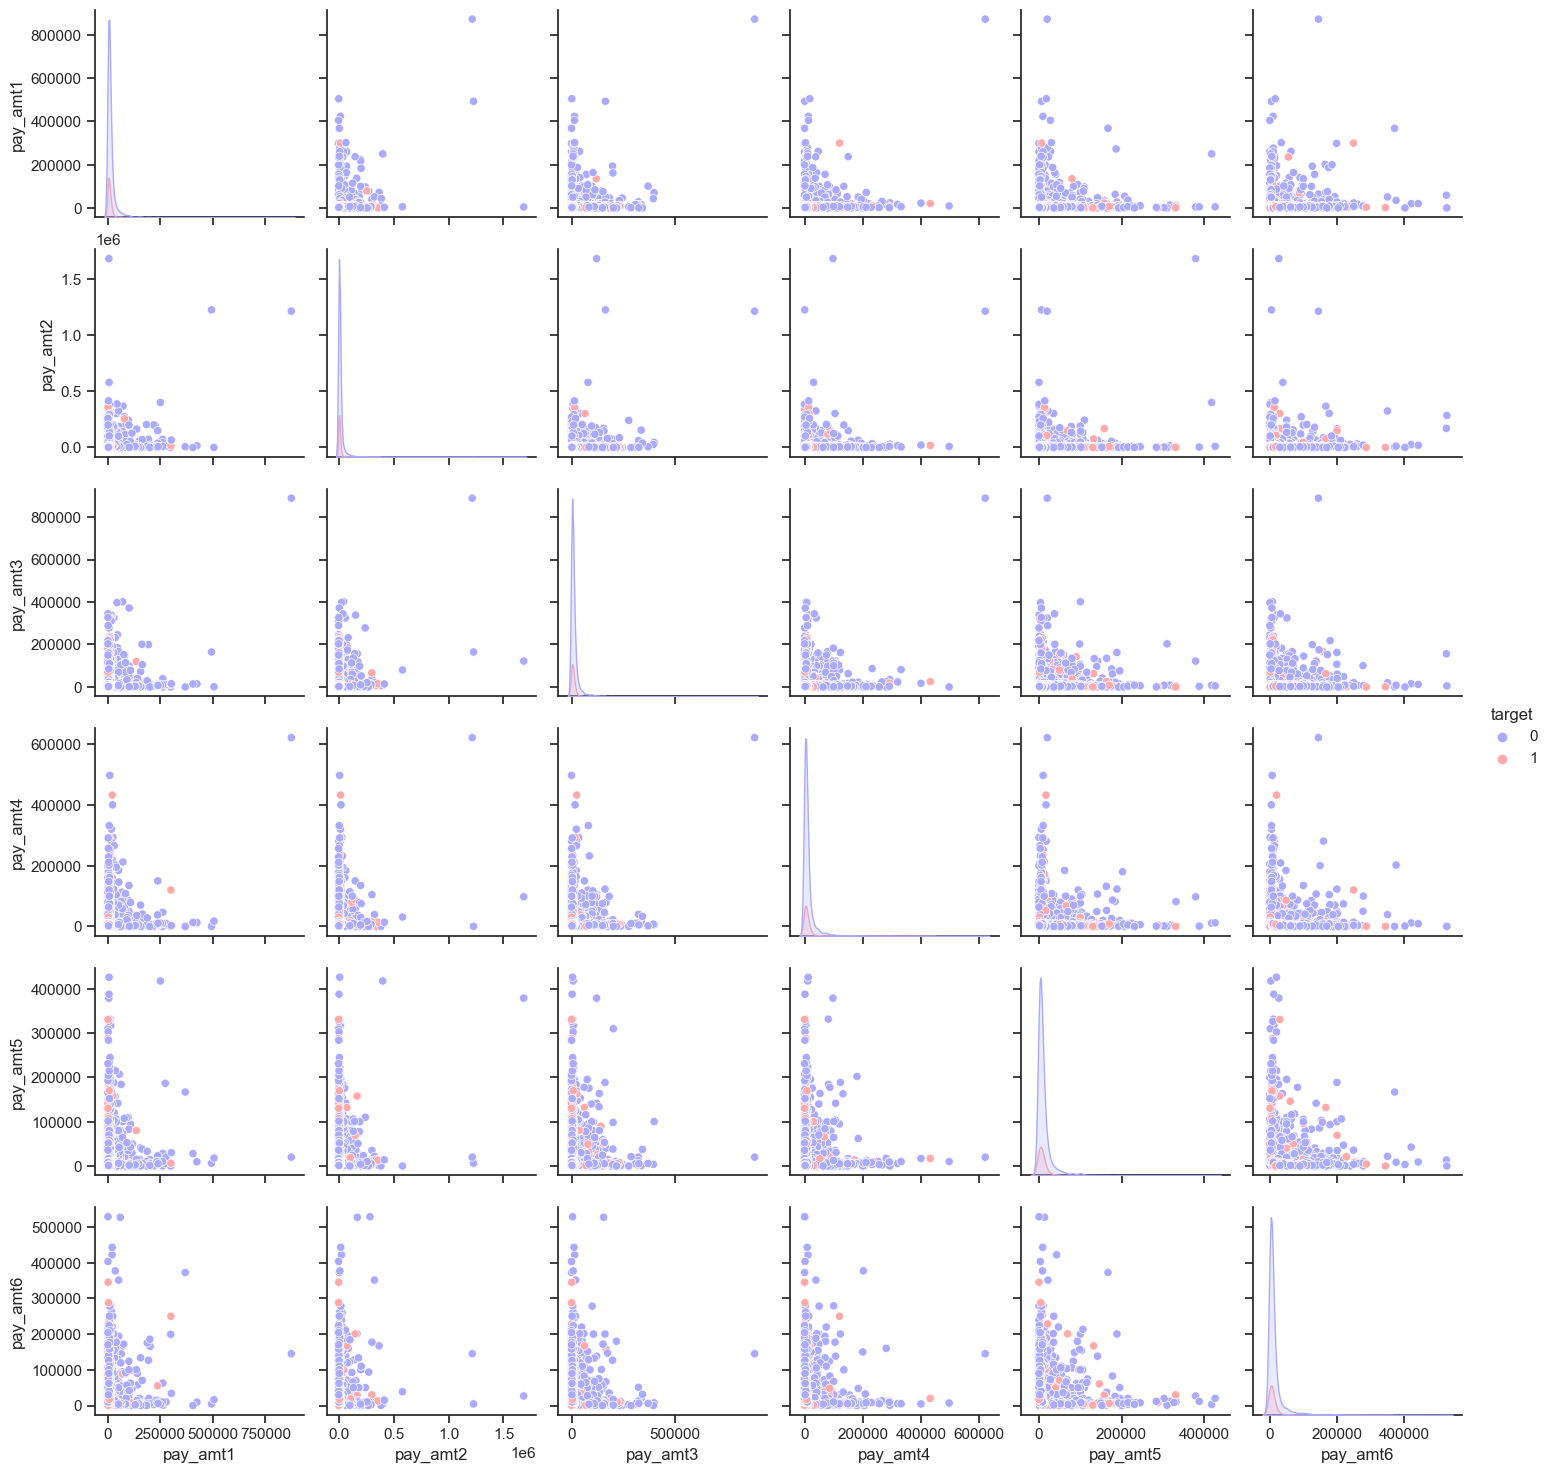

In [68]:
sns.pairplot(data=outliers[pay_amt_cols + ["target"]], hue='target', palette="bwr")

target                  0    1
pay_amt1_bin                  
(10000.0, 100000.0]  1807  247
(100000.0, inf]       107   11

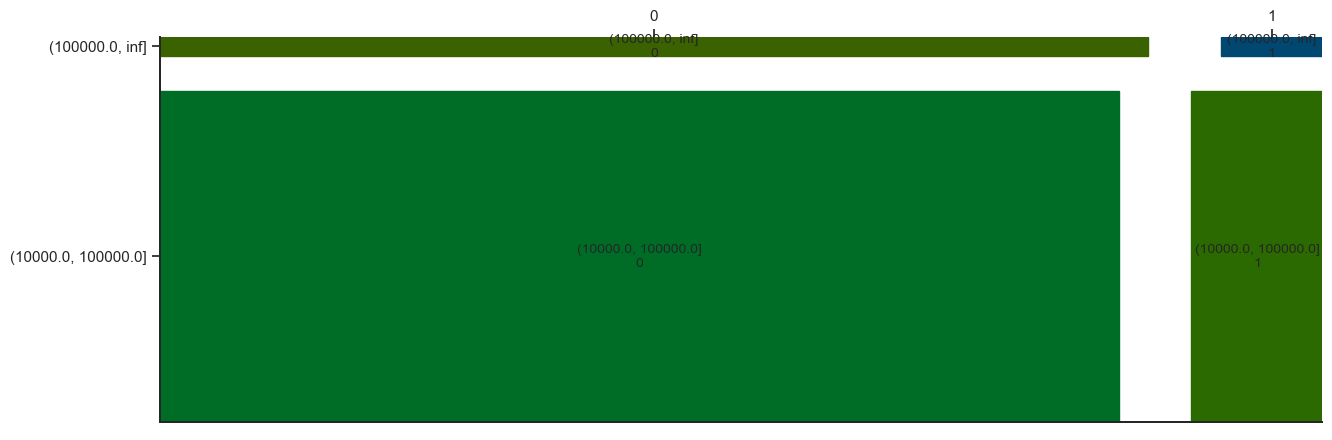

In [69]:
# Note: all months are similar when it comes to reveal independence between outliers and the target.
crosstable = pd.crosstab(pay_amt1_outliers["pay_amt1_bin"], pay_amt1_outliers["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

### Feature engineering

In [70]:
# Categorical variables:
df["is_male"] = np.where(df["sex"] == "Male", 1, 0)
df["is_married"] = np.where(df["marriage"] == "Married", 1, 0)
df["is_single"] = np.where(df["marriage"] == "Single", 1, 0)

new_education_mapping = {
    "Graduate School": 1,
    "University": 2,
    "High School": 3,
    "Others": 4,
    "Unknown": 4
}
df["education"] = map_values(df["education"], new_education_mapping)

# Drop original variables:
df.drop(["sex", "marriage"], axis=1, inplace=True)

#### Bill to limit balance ratio

This variable can be calculated by dividing "bill_amtX" by "limit_bal". The goal is to give an idea of how much of the credit limit is being utilized by the client.

In [71]:
df["bill_amt1_limit_bal_ratio"] = df["bill_amt1"] / df["limit_bal"]
df["bill_amt2_limit_bal_ratio"] = df["bill_amt2"] / df["limit_bal"]
df["bill_amt3_limit_bal_ratio"] = df["bill_amt3"] / df["limit_bal"]
df["bill_amt4_limit_bal_ratio"] = df["bill_amt4"] / df["limit_bal"]
df["bill_amt5_limit_bal_ratio"] = df["bill_amt5"] / df["limit_bal"]
df["bill_amt6_limit_bal_ratio"] = df["bill_amt6"] / df["limit_bal"]

bill_amt_limit_bal_ratio_cols = ["bill_amt1_limit_bal_ratio", "bill_amt2_limit_bal_ratio", "bill_amt3_limit_bal_ratio",
                                 "bill_amt4_limit_bal_ratio", "bill_amt5_limit_bal_ratio", "bill_amt6_limit_bal_ratio"]

df[bill_amt_limit_bal_ratio_cols].describe()

bill_amt1_limit_bal_ratio  bill_amt2_limit_bal_ratio  \
count               23980.000000               23980.000000   
mean                    0.422553                   0.410346   
std                     0.409292                   0.402574   
min                    -0.619892                  -1.395540   
25%                     0.022119                   0.018196   
50%                     0.310430                   0.294510   
75%                     0.828488                   0.805700   
max                     5.309500                   5.456200   

       bill_amt3_limit_bal_ratio  bill_amt4_limit_bal_ratio  \
count               23980.000000               23980.000000   
mean                    0.390219                   0.357782   
std                     0.389405                   0.366275   
min                    -0.750000                  -1.374500   
25%                     0.015990                   0.014372   
50%                     0.269140                   0.238551   
75%                     0.750990                   0.664100   
max                     3.863200                   3.715950   

       bill_amt5_limit_bal_ratio  bill_amt6_limit_bal_ratio  
count               23980.000000               23980.000000  
mean                    0.331892                   0.317331  
std                     0.348080                   0.343890  
min                    -0.750000                  -1.509530  
25%                     0.011072                   0.007800  
50%                     0.210528                   0.185156  
75%                     0.599489                   0.578490  
max                     3.498717                   2.694100

In [72]:
bins = [-2, -0.5, 0, 0.25, 0.5, 0.75, 1, 2, 12.5]

temp = df[bill_amt_limit_bal_ratio_cols].copy()

temp['bill_amt1_limit_bal_ratio'] = pd.cut(df['bill_amt1_limit_bal_ratio'], bins)
temp['bill_amt2_limit_bal_ratio'] = pd.cut(df['bill_amt2_limit_bal_ratio'], bins)
temp['bill_amt3_limit_bal_ratio'] = pd.cut(df['bill_amt3_limit_bal_ratio'], bins)
temp['bill_amt4_limit_bal_ratio'] = pd.cut(df['bill_amt4_limit_bal_ratio'], bins)
temp['bill_amt5_limit_bal_ratio'] = pd.cut(df['bill_amt5_limit_bal_ratio'], bins)
temp['bill_amt6_limit_bal_ratio'] = pd.cut(df['bill_amt6_limit_bal_ratio'], bins)

target                        0     1
bill_amt1_limit_bal_ratio            
(-2.0, -0.5]                  2     0
(-0.5, 0.0]                1554   516
(0.0, 0.25]                7637  1548
(0.25, 0.5]                2264   610
(0.5, 0.75]                2101   743
(0.75, 1.0]                3942  1373
(1.0, 2.0]                 1154   510
(2.0, 12.5]                  21     5

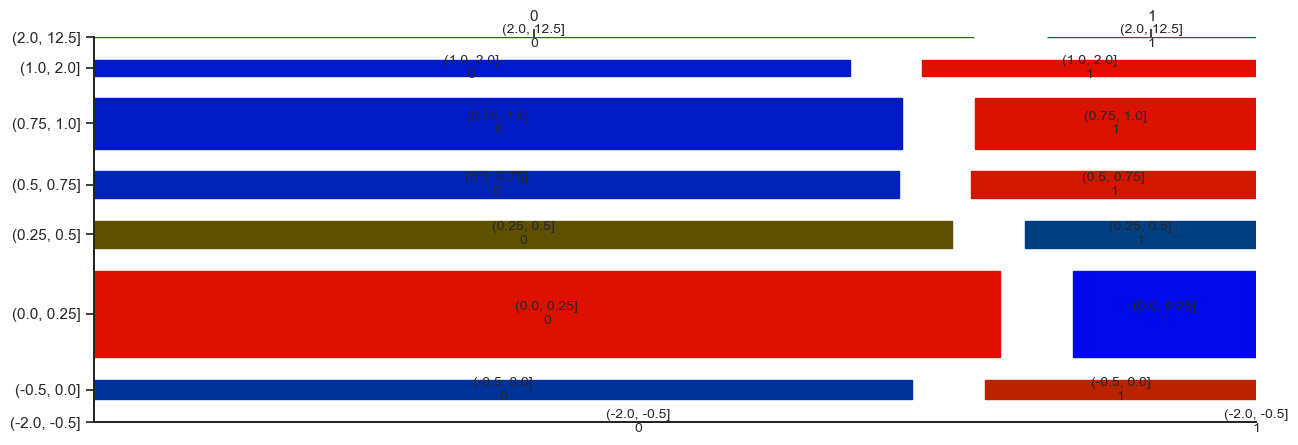

In [73]:
crosstable = pd.crosstab(temp["bill_amt1_limit_bal_ratio"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

target                        0     1
bill_amt2_limit_bal_ratio            
(-2.0, -0.5]                  2     0
(-0.5, 0.0]                1938   595
(0.0, 0.25]                7420  1481
(0.25, 0.5]                2371   590
(0.5, 0.75]                2147   758
(0.75, 1.0]                3751  1381
(1.0, 2.0]                 1026   496
(2.0, 12.5]                  20     4

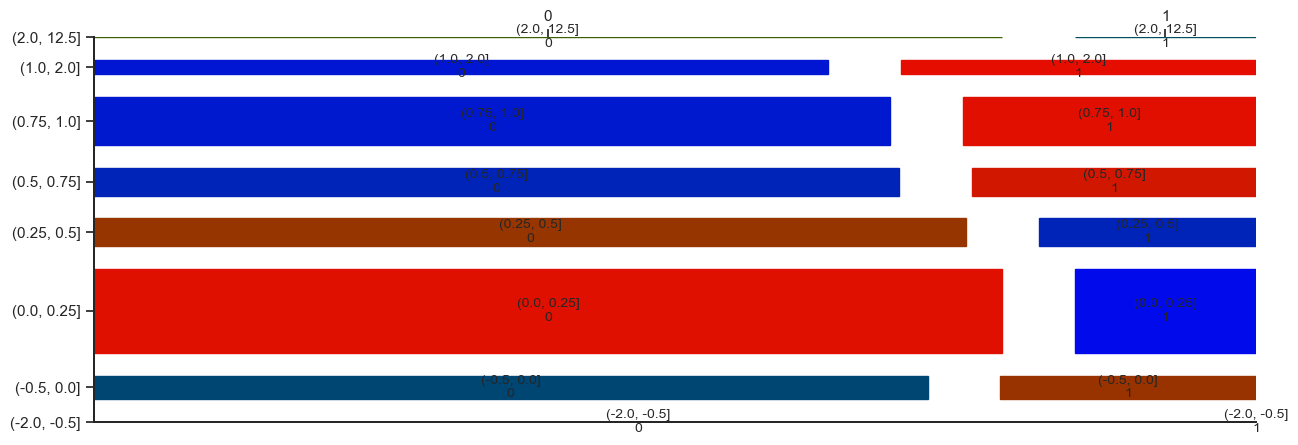

In [74]:
# Note: the other variables produce similar mosaic plots (except the month 1).
crosstable = pd.crosstab(temp["bill_amt2_limit_bal_ratio"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Pay to bill ratio

This variable can be calculated by dividing "pay_amtX" by "bill_amtX". The goal is to give an idea of how much the client is paying towards their credit card bill in relation to the total bill amount.

In [104]:
def avoid_zero_division(row, numerator, denominator):
    """Util function that replaces zeroes in denominators by a small value to perform successfully a division."""
    #if row[denominator] == 0:
    #    return 0.0 if row[numerator] == 0 else row[numerator] / 0.00001
    #else:
    #    return row[numerator] / row[denominator]
    
    if row[denominator] == 0:
        # If pay_amt is positive, it means the client has overpaid:
        return -row[numerator]
        
    return 0.0 if row[numerator] == 0 else row[numerator] / row[denominator]

In [109]:
df["pay_amt1_bill_amt1_ratio"] = df.apply(lambda row: avoid_zero_division(row, 'pay_amt1', 'bill_amt1'), axis=1)
df["pay_amt2_bill_amt2_ratio"] = df.apply(lambda row: avoid_zero_division(row, 'pay_amt2', 'bill_amt2'), axis=1)
df["pay_amt3_bill_amt3_ratio"] = df.apply(lambda row: avoid_zero_division(row, 'pay_amt3', 'bill_amt3'), axis=1)
df["pay_amt4_bill_amt4_ratio"] = df.apply(lambda row: avoid_zero_division(row, 'pay_amt4', 'bill_amt4'), axis=1) 
df["pay_amt5_bill_amt5_ratio"] = df.apply(lambda row: avoid_zero_division(row, 'pay_amt5', 'bill_amt5'), axis=1) 
df["pay_amt6_bill_amt6_ratio"] = df.apply(lambda row: avoid_zero_division(row, 'pay_amt6', 'bill_amt6'), axis=1)

pay_amt_bill_amt_ratio_cols = ["pay_amt1_bill_amt1_ratio", "pay_amt2_bill_amt2_ratio", "pay_amt3_bill_amt3_ratio",
                               "pay_amt4_bill_amt4_ratio", "pay_amt5_bill_amt5_ratio", "pay_amt6_bill_amt6_ratio"]

df[pay_amt_bill_amt_ratio_cols].describe()

pay_amt1_bill_amt1_ratio  pay_amt2_bill_amt2_ratio  \
count              23980.000000              23980.000000   
mean                 -99.375474               -195.545271   
std                 2879.903847               4540.246320   
min              -298887.000000            -285138.000000   
25%                    0.031594                  0.026203   
50%                    0.052776                  0.051075   
75%                    0.216875                  0.198057   
max                11453.666667               4388.475000   

       pay_amt3_bill_amt3_ratio  pay_amt4_bill_amt4_ratio  \
count              23980.000000              23980.000000   
mean                -190.050238               -175.258768   
std                 4054.690253               3264.172856   
min              -288921.000000            -281225.000000   
25%                    0.011970                  0.000000   
50%                    0.041822                  0.038030   
75%                    0.155114                  0.124172   
max                 3897.000000               8891.357143   

       pay_amt5_bill_amt5_ratio  pay_amt6_bill_amt6_ratio  
count              23980.000000              23980.000000  
mean                -207.836376               -241.534995  
std                 4052.597689               4722.815445  
min              -330982.000000            -279260.000000  
25%                    0.000000                 -0.000000  
50%                    0.040055                  0.039431  
75%                    0.141571                  0.144484  
max                  854.901515               2643.330000

In [114]:
n_bins = 8

temp = df[(df["pay_amt1_bill_amt1_ratio"] <= 5) & (df["pay_amt1_bill_amt1_ratio"] >= -5)][pay_amt_bill_amt_ratio_cols].copy()

temp['pay_amt1_bill_amt1_ratio'] = pd.cut(temp['pay_amt1_bill_amt1_ratio'], bins=n_bins)
temp['pay_amt2_bill_amt2_ratio'] = pd.cut(temp['pay_amt2_bill_amt2_ratio'], bins=n_bins)
temp['pay_amt3_bill_amt3_ratio'] = pd.cut(temp['pay_amt3_bill_amt3_ratio'], bins=n_bins)
temp['pay_amt4_bill_amt4_ratio'] = pd.cut(temp['pay_amt4_bill_amt4_ratio'], bins=n_bins)
temp['pay_amt5_bill_amt5_ratio'] = pd.cut(temp['pay_amt5_bill_amt5_ratio'], bins=n_bins)
temp['pay_amt6_bill_amt6_ratio'] = pd.cut(temp['pay_amt6_bill_amt6_ratio'], bins=n_bins)

target                        0     1
pay_amt1_bill_amt1_ratio             
(-4.993, -3.735]              6     1
(-3.735, -2.487]             11     1
(-2.487, -1.239]             12     0
(-1.239, 0.00842]          2861  1589
(0.00842, 1.256]          13446  3315
(1.256, 2.504]              787   126
(2.504, 3.752]              305    45
(3.752, 5.0]                188    26

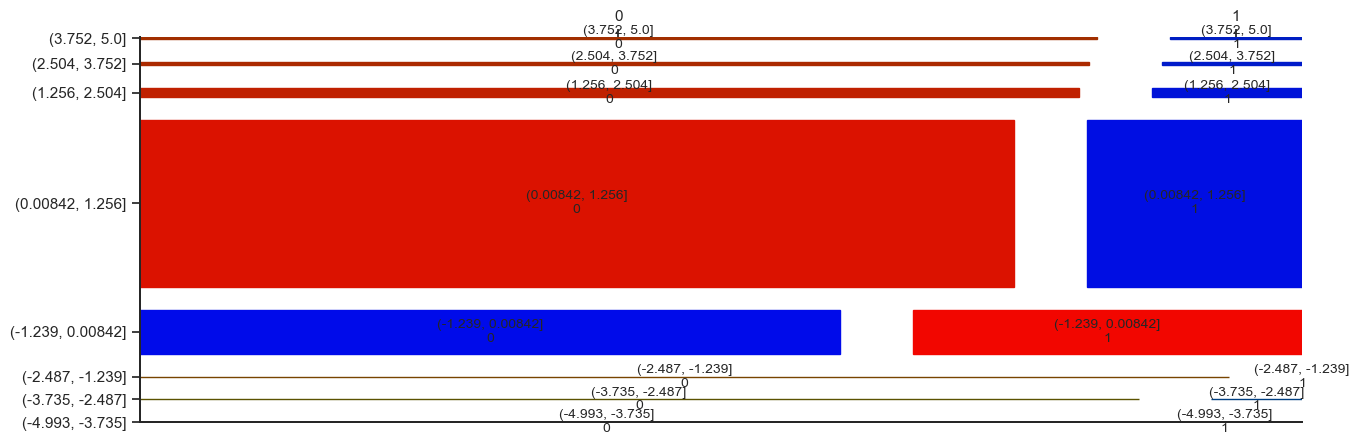

In [115]:
# Note: the other variables produce similar mosaic plots (except the month 1).
crosstable = pd.crosstab(temp["pay_amt1_bill_amt1_ratio"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Number of negative bill statements

This variable can be calculated by dividing counting the number of times a client had a negative bill statement during the past 6 months. The goal is to give an idea of how many times each client has overpaid.

In [79]:
bill_amt_cols = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]

df['num_overpays'] = (df[bill_amt_cols] < 0).sum(axis=1)
df["num_overpays"].value_counts(normalize=True)

0    0.934529
1    0.033236
2    0.013970
3    0.008424
4    0.004003
6    0.003169
5    0.002669
Name: num_overpays, dtype: float64

target            0     1
num_overpays             
0             17355  5055
1               692   105
2               280    55
3               167    35
4                76    20
5                51    13
6                54    22

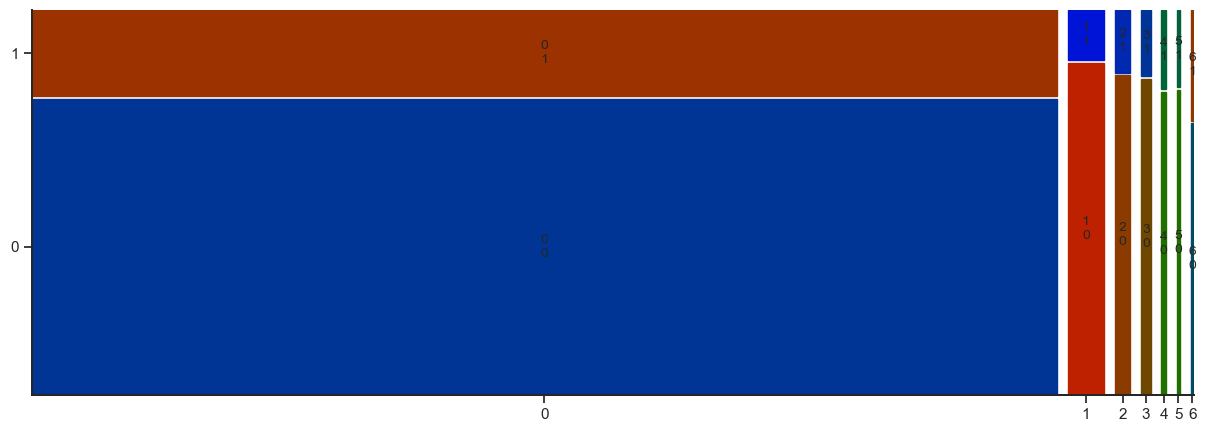

In [80]:
crosstable = pd.crosstab(df["num_overpays"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=True, gap=0.01)

display(crosstable)

#### Payment delays

This variable can be calculated by subtracting the paid amount by the bill statement. The goal is to give an idea of how many times each client does pay the entire bill and by how much it fails to pay.

In [132]:
# Note: the cases where the bill statement is negative can lead to even greater negative values of payment delays, which 
# in this context does not make sense (there isn't a delay in the payment). 
# Hence, these negative values are going to be replaced by zeroes.

df["payment_delay_amt1"] = (df["bill_amt1"] - df["pay_amt1"]).apply(lambda x: max(0, x))
df["payment_delay_amt2"] = (df["bill_amt2"] - df["pay_amt2"]).apply(lambda x: max(0, x))
df["payment_delay_amt3"] = (df["bill_amt3"] - df["pay_amt3"]).apply(lambda x: max(0, x))
df["payment_delay_amt4"] = (df["bill_amt4"] - df["pay_amt4"]).apply(lambda x: max(0, x))
df["payment_delay_amt5"] = (df["bill_amt5"] - df["pay_amt5"]).apply(lambda x: max(0, x))
df["payment_delay_amt6"] = (df["bill_amt6"] - df["pay_amt6"]).apply(lambda x: max(0, x))

payment_delay_cols = ["payment_delay_amt1", "payment_delay_amt2", "payment_delay_amt3",
                      "payment_delay_amt4", "payment_delay_amt5", "payment_delay_amt6"]

df[payment_delay_cols].describe()

TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [82]:
bins = [0, 15000, 30000, 45000, 60000, 75000, 90000, 100000, 500000, 1000000]

temp = df[payment_delay_cols].copy()

temp['payment_delay_amt1'] = pd.cut(df['payment_delay_amt1'], bins)
temp['payment_delay_amt2'] = pd.cut(df['payment_delay_amt2'], bins)
temp['payment_delay_amt3'] = pd.cut(df['payment_delay_amt3'], bins)
temp['payment_delay_amt4'] = pd.cut(df['payment_delay_amt4'], bins)
temp['payment_delay_amt5'] = pd.cut(df['payment_delay_amt5'], bins)
temp['payment_delay_amt6'] = pd.cut(df['payment_delay_amt6'], bins)

target                 0     1
payment_delay_amt6            
(0, 15000]          4353  1256
(15000, 30000]      2952  1017
(30000, 45000]      1197   385
(45000, 60000]      1137   332
(60000, 75000]       689   180
(75000, 90000]       581   169
(90000, 100000]      333   110
(100000, 500000]    2027   548
(500000, 1000000]      3     0

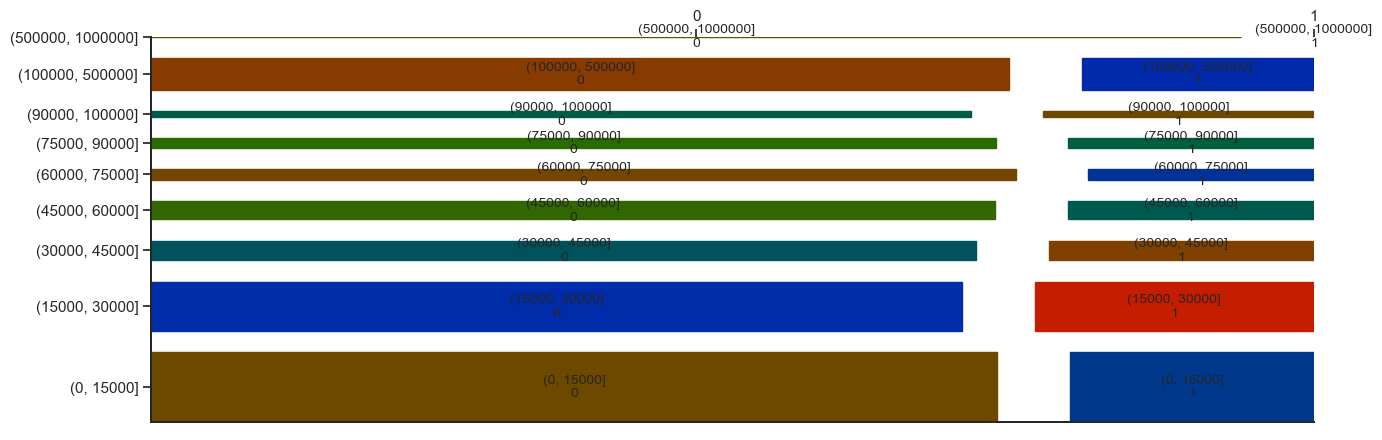

In [83]:
# Note: the other variables produce similar mosaic plots.
crosstable = pd.crosstab(temp["payment_delay_amt6"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Payment change rate

This variable can be calculated by the sum of pay amounts in two consecutive months divided by the pay amount of the first month. The goal is to give an idea of the change rate in the amount paid by the client from one month to the next.

In [129]:
def calculate_payment_change_rate(row, pay_amt1, pay_amt2):
    """Calculates the payment change rate between two consecutive months."""
    if row[pay_amt1] == 0:
        return 0.0
    else:
        return (row[pay_amt2] - row[pay_amt1] / row[pay_amt1])

In [136]:
df['payment_change_rate_amt1_amt2'] = df.apply(lambda x: calculate_payment_change_rate(x, "pay_amt1", "pay_amt2"), axis=1)
df['payment_change_rate_amt2_amt3'] = df.apply(lambda x: calculate_payment_change_rate(x, "pay_amt2", "pay_amt3"), axis=1)
df['payment_change_rate_amt3_amt4'] = df.apply(lambda x: calculate_payment_change_rate(x, "pay_amt3", "pay_amt4"), axis=1)
df['payment_change_rate_amt4_amt5'] = df.apply(lambda x: calculate_payment_change_rate(x, "pay_amt4", "pay_amt5"), axis=1)
df['payment_change_rate_amt5_amt6'] = df.apply(lambda x: calculate_payment_change_rate(x, "pay_amt5", "pay_amt6"), axis=1)

payment_change_rate_cols = ["payment_change_rate_amt1_amt2", "payment_change_rate_amt2_amt3",
                            "payment_change_rate_amt3_amt4", "payment_change_rate_amt4_amt5",
                            "payment_change_rate_amt5_amt6"]

df[payment_change_rate_cols].describe()

payment_change_rate_amt1_amt2  payment_change_rate_amt2_amt3  \
count                   2.398000e+04                   23980.000000   
mean                    5.323669e+03                    4657.817306   
std                     2.260731e+04                   15661.159880   
min                    -1.000000e+00                      -1.000000   
25%                     0.000000e+00                       0.000000   
50%                     1.934500e+03                    1499.000000   
75%                     4.710000e+03                    3999.000000   
max                     1.684258e+06                  889042.000000   

       payment_change_rate_amt3_amt4  payment_change_rate_amt4_amt5  \
count                   23980.000000                   23980.000000   
mean                     4263.824937                    4279.011009   
std                     14449.124099                   14620.120775   
min                        -1.000000                      -1.000000   
25%                         0.000000                       0.000000   
50%                      1091.500000                    1099.000000   
75%                      3683.000000                    3599.000000   
max                    620999.000000                  426528.000000   

       payment_change_rate_amt5_amt6  
count                   23980.000000  
mean                     4609.906088  
std                     16952.770917  
min                        -1.000000  
25%                         0.000000  
50%                      1029.500000  
75%                      3622.500000  
max                    528665.000000

In [142]:
bins = [-1, -0.5, 0, 0.20, 0.40, 0.6, 0.8, 1.0]

temp = df[payment_change_rate_cols].copy()

temp['payment_change_rate_amt1_amt2'] = pd.cut(df['payment_change_rate_amt1_amt2'], bins=n_bins)
temp['payment_change_rate_amt2_amt3'] = pd.cut(df['payment_change_rate_amt2_amt3'], bins=n_bins)
temp['payment_change_rate_amt3_amt4'] = pd.cut(df['payment_change_rate_amt3_amt4'], bins=n_bins)
temp['payment_change_rate_amt4_amt5'] = pd.cut(df['payment_change_rate_amt4_amt5'], bins=n_bins)
temp['payment_change_rate_amt5_amt6'] = pd.cut(df['payment_change_rate_amt5_amt6'], bins=n_bins)

target                             0     1
payment_change_rate_amt1_amt2             
(-1685.259, 336850.8]          18666  5303
(336850.8, 673702.6]               6     2
(1010554.4, 1347406.2]             2     0
(1347406.2, 1684258.0]             1     0

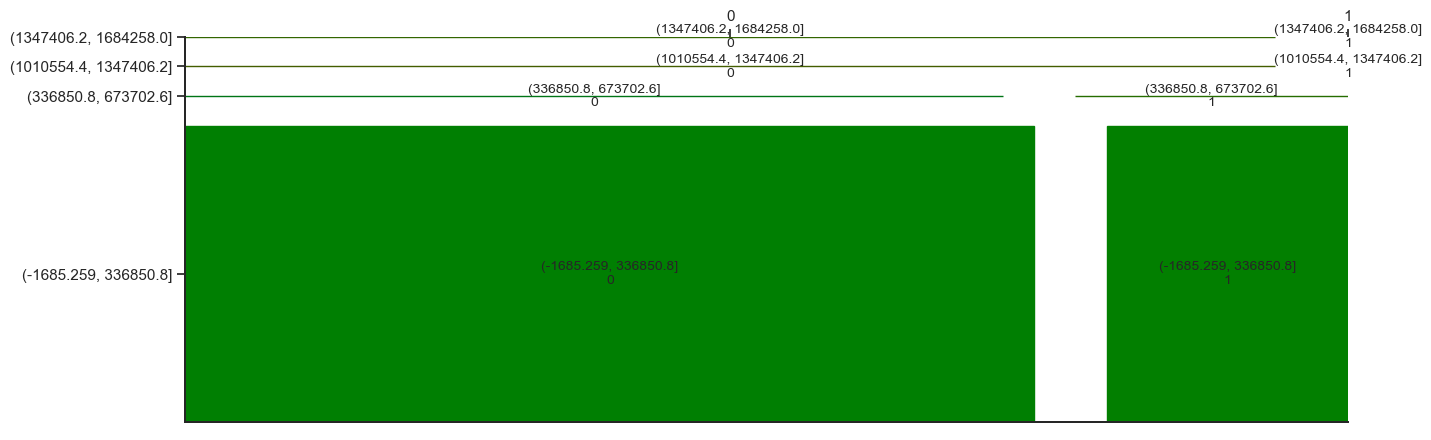

In [143]:
# Note: the other variables produce similar mosaic plots.
crosstable = pd.crosstab(temp["payment_change_rate_amt1_amt2"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Bill change rate

This variable can be calculated by the sum of bill statement amounts in two consecutive months divided by the bill statement amount of the first month. The goal is to give an idea of the change rate in the credit card bill from one month to the next.

In [87]:
df['bill_change_rate_amt1_amt2'] = (df['bill_amt1'] - df['bill_amt2']) / df['bill_amt1']
df['bill_change_rate_amt2_amt3'] = (df['bill_amt2'] - df['bill_amt3']) / df['bill_amt2']
df['bill_change_rate_amt3_amt4'] = (df['bill_amt3'] - df['bill_amt4']) / df['bill_amt3']
df['bill_change_rate_amt4_amt5'] = (df['bill_amt4'] - df['bill_amt5']) / df['bill_amt4']
df['bill_change_rate_amt5_amt6'] = (df['bill_amt5'] - df['bill_amt6']) / df['bill_amt5']

bill_change_rate_cols = ["bill_change_rate_amt1_amt2", "bill_change_rate_amt2_amt3",
                            "bill_change_rate_amt3_amt4", "bill_change_rate_amt4_amt5",
                            "bill_change_rate_amt5_amt6"]

df[bill_change_rate_cols].describe()

bill_change_rate_amt1_amt2  bill_change_rate_amt2_amt3  \
count                2.282500e+04                2.251300e+04   
mean                          NaN                         NaN   
std                           NaN                         NaN   
min                          -inf                        -inf   
25%                 -6.234682e-02               -5.895669e-02   
50%                  0.000000e+00                0.000000e+00   
75%                  1.243767e-01                1.562325e-01   
max                           inf                         inf   

       bill_change_rate_amt3_amt4  bill_change_rate_amt4_amt5  \
count                2.221800e+04                2.203400e+04   
mean                          NaN                         NaN   
std                           NaN                         NaN   
min                          -inf                        -inf   
25%                 -4.027256e-02               -3.150849e-02   
50%                  5.341659e-03                1.639615e-03   
75%                  2.216397e-01                2.308116e-01   
max                           inf                         inf   

       bill_change_rate_amt5_amt6  
count                2.176500e+04  
mean                          NaN  
std                           NaN  
min                          -inf  
25%                 -3.903265e-02  
50%                  0.000000e+00  
75%                  1.515581e-01  
max                           inf

In [88]:
bins = [-np.Infinity, -0.5, 0, 0.20, 0.40, 0.6, 0.8, 1.0, np.Infinity]

temp = df[bill_change_rate_cols].copy()

temp['bill_change_rate_amt1_amt2'] = pd.cut(df['bill_change_rate_amt1_amt2'], bins=bins)
temp['bill_change_rate_amt2_amt3'] = pd.cut(df['bill_change_rate_amt2_amt3'], bins=bins)
temp['bill_change_rate_amt3_amt4'] = pd.cut(df['bill_change_rate_amt3_amt4'], bins=bins)
temp['bill_change_rate_amt4_amt5'] = pd.cut(df['bill_change_rate_amt4_amt5'], bins=bins)
temp['bill_change_rate_amt5_amt6'] = pd.cut(df['bill_change_rate_amt5_amt6'], bins=bins)

target                         0     1
bill_change_rate_amt1_amt2            
(-inf, -0.5]                1859   338
(-0.5, 0.0]                 7046  2454
(0.0, 0.2]                  4396  1387
(0.2, 0.4]                  1088   168
(0.4, 0.6]                   805   136
(0.6, 0.8]                   571    83
(0.8, 1.0]                  1329   242
(1.0, inf]                   430    73

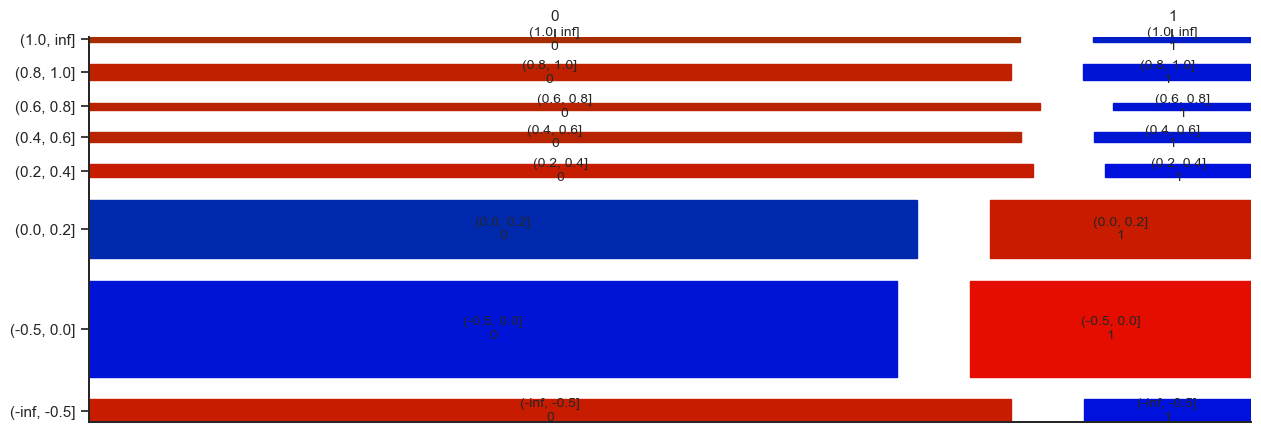

In [89]:
# Note: the other variables produce similar mosaic plots.
crosstable = pd.crosstab(temp["bill_change_rate_amt1_amt2"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

#### Total payment

This variable is calculated by the sum of the total amount paid by the client over the given time period. The goal is to give an idea of the client's ability and willingness to pay their debts. 

In [90]:
df["total_payment"] = (df[pay_amt_cols]).sum(axis=1)
df[["total_payment"]].describe()

total_payment
count   2.398000e+04
mean    3.151451e+04
std     6.124985e+04
min     0.000000e+00
25%     6.699000e+03
50%     1.435650e+04
75%     3.328825e+04
max     3.764066e+06

In [91]:
bins = [0, 1000, 15000, 20000, 50000, 100000, 500000, 1000000, np.Infinity]
df["total_payment_bin"] = pd.cut(df['total_payment'], bins=bins)

target                    0     1
total_payment_bin                
(0.0, 1000.0]           289   107
(1000.0, 15000.0]      7894  2935
(15000.0, 20000.0]     1606   399
(20000.0, 50000.0]     4866   999
(50000.0, 100000.0]    1931   283
(100000.0, 500000.0]   1356   140
(500000.0, 1000000.0]    28     2
(1000000.0, inf]          4     0

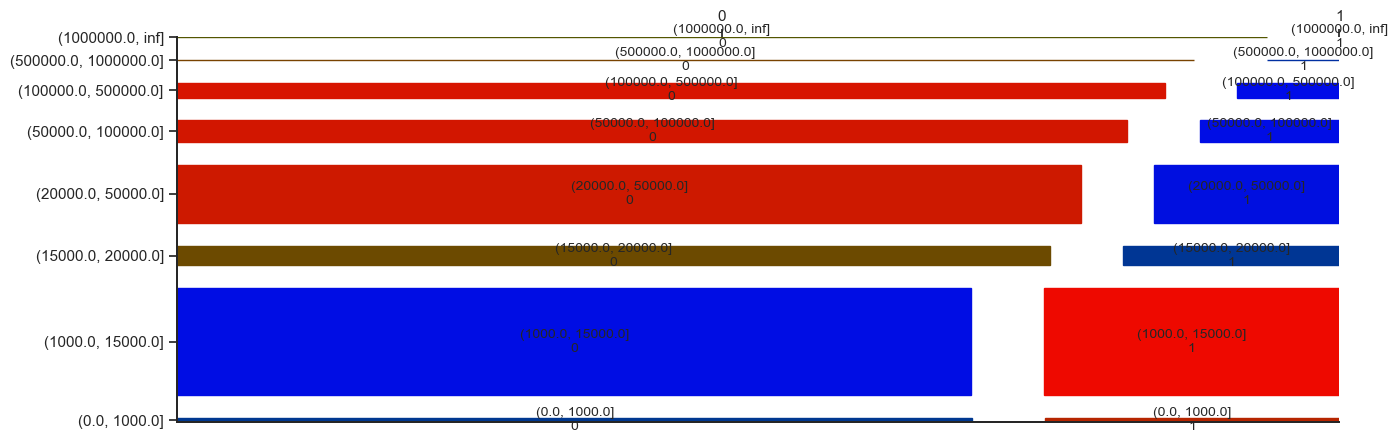

In [92]:
crosstable = pd.crosstab(df["total_payment_bin"], df["target"])

fig, ax = plt.subplots(figsize=(15,5))
_ = mosaic(crosstable.stack(), statistic=True, ax=ax, horizontal=False, gap=0.1)

display(crosstable)

In [93]:
df[["total_payment", "target"]].groupby("target").describe()

total_payment                                                    \
               count          mean           std  min     25%      50%   
target                                                                   
0            18675.0  34756.647818  66178.738683  0.0  7414.0  16400.0   
1             5305.0  20101.347220  37062.704789  0.0  4876.0   9800.0   

                            
            75%        max  
target                      
0       37000.0  3764066.0  
1       21458.0   704208.0